# Lab 4: Non-negative Matrix Factorization

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD4"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L4_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from sklearn.utils       import check_random_state
from sklearn.datasets    import fetch_olivetti_faces

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds        = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

dataset          = fetch_olivetti_faces(shuffle=True)
faces            = dataset.data.T #on représente chaque image par une colonne, en accord avec le cours
faces[3523][338] = 1e-2 #l'un des éléments de faces est nul, ce qui bloque la divergence de KL

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
W \leftarrow W \circ \frac{X H^{\top}}{W (H H^{\top} + {\color{red} \nu I_r})} \\
H \leftarrow H \circ \frac{W^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(W^{\top} W + {\color{red} \mu I_r})H}
\end{array}

Fill in the following NMF class:

In [2]:
import numpy as np
from scipy.special import softmax

class MYNMF:
    """ Class for NMF:
    
    Attributes:                                                                                 
    -----------                                                Default value
    n_components_ : integer,  unknown dimension of W and H   | 20                
    max_iter_     : integer,  maximum number of iterations   | 60
    epsilon_      : float,    epsilon coefficient            | 1e-4
    loss_         : str,      {"Frobenius", "KL"}            | Frobenius
    D_            : np.array, W Matrix factor                | None
    S_            : np.array, H Matrix factor                | None
    D_history     : list,     W Matrix history               | []
    S_history     : list,     H Matrix history               | []
    loss_history  : list,     history of loss                | []
    random_state  : int,      for the random initialization  | 42
    
    """

    def __init__(self, n_components=20, max_iter=200, epsilon=1e-5, loss="Frobenius", random_state=42):
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.epsilon_ = epsilon
        self.loss_ = loss
        self.D_ = None
        self.S_ = None
        self.D_history = []
        self.S_history = []
        self.loss_history = []
        self.random_state = random_state

    def fit_transform(self, data, mu=5e-3, nu=5e-3, lambd=1e-3):
        """Fits NMF model to the data and finds factors D and S.
        
        Parameters:
        -----------
        data : np.array, shape (p, n)
            Input data matrix.
        mu : float
            Regularization parameter for H.
        nu : float
            Regularization parameter for W.
        lambd : float
            Sparsity regularization parameter for H.
        
        Returns:
        --------
        W : np.array, shape (p, r)
            Basis matrix D (embedding matrix).
        """
        
        # Loss calculation with chosen metric
        def compute_loss(W, H):
            if self.loss_ == "Frobenius":
                return 0.5 * np.linalg.norm(data - W @ H, 'fro') ** 2 + \
                       mu / 2 * np.linalg.norm(H, 'fro') ** 2 + lambd * np.linalg.norm(H, 1) + nu / 2 * np.linalg.norm(W, 'fro') ** 2
            elif self.loss_ == "KL":
                WH = np.dot(W, H)
                return np.sum(data * np.log(data / (WH + 1e-10) + 1e-10) - data + WH)

        p, n = data.shape
        r = self.n_components_
        np.random.seed(self.random_state)
        W = np.abs(np.random.rand(p, r))  # initialize W with non-negative values
        H = np.abs(np.random.rand(r, n))  # initialize H with non-negative values

        
        for iter in range(self.max_iter_):
            if self.loss_ == "Frobenius":
                # Update rules ensuring non-negativity
                WH = np.dot(W, H)
                
                # Update W with non-negativity constraints
                W_mult = (data @ H.T) / (WH @ H.T + nu * W + 1e-10)  # add a small constant to avoid division by zero
                W = np.multiply(W, W_mult)

                # Update H with non-negativity constraints
                H_mult = (W.T @ data - lambd) / (W.T @ W @ H + mu * H + 1e-10)
                H = np.multiply(H, H_mult)

            elif self.loss_ == "KL":
                WH = W @ H

                # Update W
                WH_ratio = data / (WH + 1e-10)  # small epsilon to avoid division by zero
                W *= (WH_ratio @ H.T) / (np.sum(H, axis=1) + 1e-10)

                # Update H
                WH = W @ H  # Recompute WH after updating W
                WH_ratio = data / (WH + 1e-10)  # small epsilon to avoid division by zero
                H *= (W.T @ WH_ratio) / (np.sum(W, axis=0)[:, np.newaxis] + 1e-10)

            # Calculate and record the loss 
            loss = compute_loss(W, H)

            self.loss_history.append(loss)

            self.D_history.append(W)
            self.S_history.append(H)

            if abs(self.loss_history[-1]) < self.epsilon_:
                break   

        self.D_ = W
        self.S_ = H
        return self.D_

    def predict_label(self, X):
        """ Predict cluster assignments for X (hard assignment).
        
        Parameters:
        -----------
        X : np.array, shape (n, p)
            Input data.
        
        Returns:
        --------
        labels : np.array, shape (p,)
            Cluster labels for each data point.
        """
        if self.D_ is None:
            raise ValueError("Model has not been fitted yet. Call fit_transform first.")
        embedding = self.D_.T @ X.T
        return np.argmax(embedding, axis=0)

    def predict_proba(self, X):
        """ Predict cluster probabilities for X (soft assignment).
        
        Parameters:
        -----------
        X : np.array, shape (n, p)
            Input data.
        
        Returns:
        --------
        probabilities : np.array, shape (n, r)
            Probability of each class.
        """
        if self.D_ is None:
            raise ValueError("Model has not been fitted yet. Call fit_transform first.")
        embedding = self.D_.T @ X.T
        return softmax(embedding, axis=0).T

## Hyperparameter optimization

### Regularization parameter : mu

In [5]:
#TODO : find best mu
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
import numpy as np

mus = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50]
losses = []

# Create subplots for loss history and Loss vs mu
fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss History", "Loss vs mu"))

# Plot loss history for each mu
for mu in tqdm(mus):
    nmf = MYNMF(max_iter=200)
    nmf.fit_transform(faces, mu=mu)
    losses.append(nmf.loss_history[-1])

    # Add loss history for current mu
    fig.add_trace(
        go.Scatter(y=nmf.loss_history, mode='lines', name=f"mu = {mu}"),
        row=1, col=1
    )

# Configure the Loss vs mu plot
fig.add_trace(
    go.Scatter(
        x=np.log10(mus), 
        y=losses, 
        mode='lines+markers', 
        name="Loss vs mu"
    ),
    row=1, col=2
)

# Update layout and axis labels
fig.update_layout(
    title="Loss as a Function of mu",
    height=500,
    width=1000,
    showlegend=True
)

fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1, range=[1000, 20000])
fig.update_xaxes(title_text="log(mu)", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=2)

# Show the interactive plot
fig.show()


100%|██████████| 7/7 [01:50<00:00, 15.78s/it]


We observe that, for different values of the regularization parameter $\mu$, the loss tends to converge as iterations progress. However, as $\mu$ increases, there is a significant rise in the final loss value after convergence. 

This trend can be attributed to the regularization term involving $\mu\$ and the Frobenius norm of matrix H. When $\mu$ is low, the regularization term has a minimal impact, allowing the model to closely approximate the original data by minimizing reconstruction error. However, as $\mu$ grows, the regularization term $\frac{\mu}{2} \|H\|_F^2$ dominates the objective function, enforcing a stronger penalty on the norm of H . This effectively constrains H  and  D from learning finer details of the data structure, resulting in a higher overall loss.

Interestingly, this increase in loss does not necessarily indicate overfitting, but rather the opposite— a form of underfitting. With high $\mu$, the factorization becomes overly constrained, potentially failing to capture complex patterns in the data. This regularization effect may prevent H from adapting freely to the data structure, leading to a loss of information that results in a higher reconstruction error.



### Regularization parameter : nu

In [6]:
#TODO : find best nu


bst_mu = 1e-4
nus = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50]
losses = []

# Create subplots for loss history and Loss vs nu
fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss History", "Loss vs nu"))

# Plot loss history for each nu
for nu in tqdm(nus):
    nmf = MYNMF(max_iter=200)
    nmf.fit_transform(faces, nu=nu, mu=bst_mu)
    losses.append(nmf.loss_history[-1])

    # Add loss history for current nu
    fig.add_trace(
        go.Scatter(y=nmf.loss_history, mode='lines', name=f"nu = {nu}"),
        row=1, col=1
    )

# Configure the Loss vs nu plot
fig.add_trace(
    go.Scatter(
        x=np.log10(nus), 
        y=losses, 
        mode='lines+markers', 
        name="Loss vs nu"
    ),
    row=1, col=2
)

# Update layout and axis labels
fig.update_layout(
    title="Loss as a Function of nu",
    height=500,
    width=1000,
    showlegend=True
)

fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1, range=[1000, 20000])
fig.update_xaxes(title_text="log(nu)", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=2)

# Show the interactive plot
fig.show()


100%|██████████| 7/7 [01:43<00:00, 14.73s/it]


We observe a similar behavior for the regularization parameter $\nu$ as we did with $\nu$. For different values of $\nu$, the loss eventually converges as iterations progress. However, as $\nu$ increases, the final converged loss also rises significantly.

This increase in loss is attributed to the regularization term involving $\nu$ and the Frobenius norm of matrix W. When $\nu$ is small, this term has little effect, allowing the model to closely approximate the original data by minimizing reconstruction error. As $\nu$ increases, the regularization term $\frac{\nu}{2} \|W\|_F^2$ begins to dominate the objective function, placing a stronger constraint on W. This limits the model's ability to adjust W to capture complex patterns in the data, resulting in higher reconstruction error.

Similar to the case with $\mu$, the increase in loss with larger $\nu$ suggests that the model is underfitting rather than overfitting. Here, the strong regularization forces W to remain relatively small and simple, reducing the model’s flexibility and causing it to overlook finer details in the data.


### Regularization parameter : lambda

In [9]:
#TODO : find best lambda

bst_mu = 1e-4
bst_nu = 1e-3
lambds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50]
losses = []

# Create subplots for loss history and Loss vs lambd
fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss History", "Loss vs lambd"))

# Plot loss history for each lambd
for lambd in tqdm(lambds):
    nmf = MYNMF(max_iter=200)
    nmf.fit_transform(faces, lambd=lambd, mu=bst_mu, nu=bst_nu)
    losses.append(nmf.loss_history[-1])

    # Add loss history for current lambd
    fig.add_trace(
        go.Scatter(y=nmf.loss_history, mode='lines', name=f"lambd = {lambd}"),
        row=1, col=1
    )

# Configure the Loss vs lambd plot
fig.add_trace(
    go.Scatter(
        x=np.log10(lambds), 
        y=losses, 
        mode='lines+markers', 
        name="Loss vs lambd"
    ),
    row=1, col=2
)

# Update layout and axis labels
fig.update_layout(
    title="Loss as a Function of lambd",
    height=500,
    width=1000,
    showlegend=True
)

fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1, range=[1000, 20000])
fig.update_xaxes(title_text="log(lambd)", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=2)

# Show the interactive plot
fig.show()


100%|██████████| 9/9 [02:53<00:00, 19.32s/it]


We observe the same behaviour as before, but this time the increase in loss could be attributed to $\lambda\|H\|_1$

In [8]:
#TODO : check results for mu, nu and lambda with new obtained regularization parameters

import plotly.express as px

# Parameters
bst_mu = 1e-4 
bst_nu = 1e-4
bst_lambd = 1e-6

# Fit NMF model
nmf = MYNMF()
embeddings = nmf.fit_transform(faces, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
probas = nmf.predict_proba(faces.T)

# Plot embeddings using Plotly
fig = px.scatter(
    x=embeddings[:, 0],
    y=embeddings[:, 1],
    title="NMF Embeddings",
    labels={"x": "Embedding Dimension 1", "y": "Embedding Dimension 2"}
)

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(width=800, height=800)
fig.show()


**Remarks**: This visualization suggests that the NMF is capturing meaningful structure, but the clustering of points near the origin indicates that most of the data is somewhat homogenous or that higher dimensions may capture more variance. Exploring further using higher-dimensional embeddings or different parameter settings for NMF to fully understand how it decomposes the data is needed.

### Number of components

We are going to determine the **optimal number of components** for the factorization by plotting the final loss after 100 epochs for different number of components.
We expect an **elbow curve**, and we will choose the value at the elbow point. Indeed, the higher the number of components is, the more precise the atoms of the dictionary can be, and thus the more precise the reconstructed image will be.
We will find the optimal parameter both for Frobenius and Kullback-Leibler distances.

#### Case of Frobenius distance

In [16]:
#TODO : find best n_componenta

bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
n_components = range(20, 110, 10)
losses = []

# Create subplots for loss history and Loss vs n_component
fig = make_subplots(rows=1, cols=2, subplot_titles=("Frobenius Loss History", "Frobenius Loss vs n_component"))

# Plot loss history for each n_component
for n_component in tqdm(n_components):
    nmf = MYNMF(max_iter=100, n_components=n_component)
    nmf.fit_transform(faces, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
    losses.append(nmf.loss_history[-1])

    # Add loss history for current n_component
    fig.add_trace(
        go.Scatter(y=nmf.loss_history, mode='lines', name=f"n_component = {n_component}"),
        row=1, col=1
    )

# Configure the Loss vs n_component plot
fig.add_trace(
    go.Scatter(
        x=list(n_components), 
        y=losses, 
        mode='lines+markers', 
        name="Frobenius Loss vs n_component"
    ),
    row=1, col=2
)

# Update layout and axis labels
fig.update_layout(
    title="Frobenius Loss as a Function of n_component",
    height=500,
    width=1000,
    showlegend=True
)

fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_yaxes(title_text="Frobenius Loss", row=1, col=1, range=[4000, 30000])
fig.update_xaxes(title_text="n_component", row=1, col=2)
fig.update_yaxes(title_text="Frobenius Loss", row=1, col=2)

# Show the interactive plot
fig.show()

100%|██████████| 9/9 [01:38<00:00, 10.99s/it]


The Frobenius loss decreases as the number of components increases, but after a certain point, the rate of decrease slows down. This "elbow" in the plot is where the improvement in fit becomes marginal, which suggests that adding more components beyond this point does not provide significant additional information.
The elbow point appears ti be arround 40-50 components.

#### Case of Kullback-Leibler divergence

In [17]:
#TODO

bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
n_components = range(20, 110, 10)
losses = []

# Create subplots for loss history and Loss vs n_component
fig = make_subplots(rows=1, cols=2, subplot_titles=("KL Loss History", "KL Loss vs n_component"))

# Plot loss history for each n_component
for n_component in tqdm(n_components):
    nmf = MYNMF(max_iter=100, n_components=n_component, loss= "KL")
    nmf.fit_transform(faces, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
    losses.append(nmf.loss_history[-1])

    # Add loss history for current n_component
    fig.add_trace(
        go.Scatter(y=nmf.loss_history, mode='lines', name=f"n_component = {n_component}"),
        row=1, col=1
    )

# Configure the Loss vs n_component plot
fig.add_trace(
    go.Scatter(
        x=list(n_components), 
        y=losses, 
        mode='lines+markers', 
        name="KL Loss vs n_component"
    ),
    row=1, col=2
)

# Update layout and axis labels
fig.update_layout(
    title="KL Loss as a Function of n_component",
    height=500,
    width=1000,
    showlegend=True
)

fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_yaxes(title_text="KL Loss", row=1, col=1, range=[8000, 30000])
fig.update_xaxes(title_text="n_component", row=1, col=2)
fig.update_yaxes(title_text="KL Loss", row=1, col=2)

# Show the interactive plot
fig.show()

100%|██████████| 9/9 [03:12<00:00, 21.43s/it]


The same behaviour as for Frobenius distance is observed here. We note that the elbow point is around 40-50 components.

## Comparison between the two distances

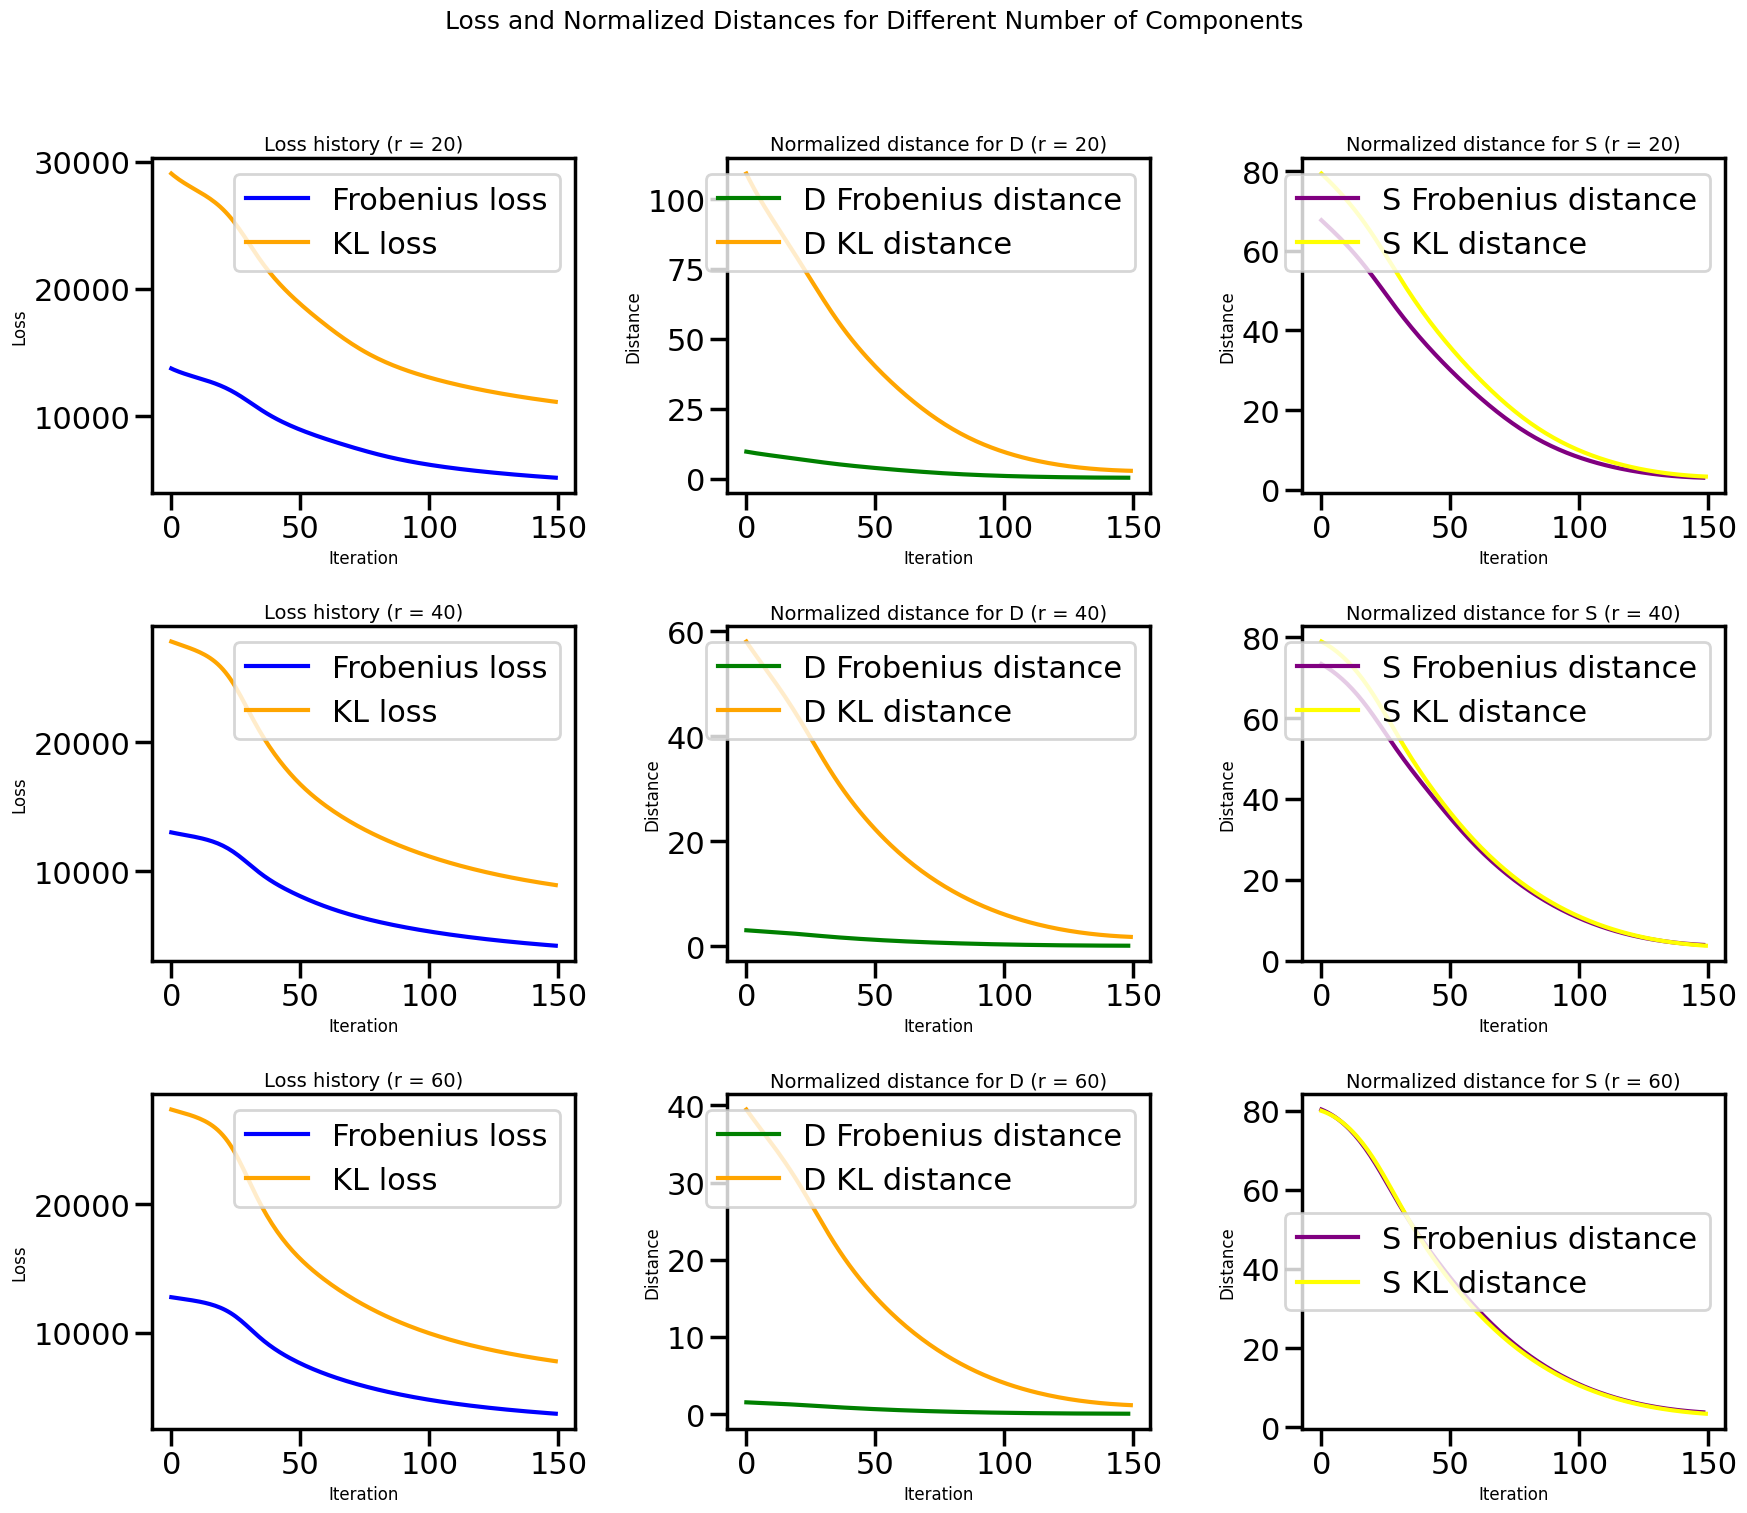

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming MYNMF is defined and faces is your dataset
max_iter = 150
bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
rs = [20, 40, 60]

# Create a large figure for better spacing
fig, ax = plt.subplots(len(rs), 3, figsize=(18, 5*len(rs)))

# Iterate over the different r values
for i, r in enumerate(rs):
    # Frobenius loss computation
    loss = "Frobenius"
    nmf_frob = MYNMF(max_iter=max_iter, n_components=r, loss=loss)
    nmf_frob.fit_transform(faces, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
    frob_losses = nmf_frob.loss_history
    S_hist_frob = nmf_frob.S_history
    D_hist_frob = nmf_frob.D_history

    # KL loss computation
    loss = "KL"
    nmf_kl = MYNMF(max_iter=max_iter, n_components=r, loss=loss)
    nmf_kl.fit_transform(faces, mu=mu, nu=nu, lambd=lambd)
    kl_losses = nmf_kl.loss_history
    S_hist_kl = nmf_kl.S_history
    D_hist_kl = nmf_kl.D_history

    # Plot the loss history (Frobenius and KL)
    ax[i, 0].plot(frob_losses, label="Frobenius loss", color='blue')
    ax[i, 0].plot(kl_losses, label="KL loss", color='orange')
    ax[i, 0].set_title(f"Loss history (r = {r})", fontsize=14)
    ax[i, 0].set_xlabel("Iteration", fontsize=12)
    ax[i, 0].set_ylabel("Loss", fontsize=12)
    ax[i, 0].legend()

    # Calculate Frobenius distance for D and S
    D_frobenius_norm = [np.linalg.norm(D_hist_frob[j] - D_hist_kl[j], ord="fro")**2 for j in range(1, len(D_hist_frob))]
    S_frobenius_norm = [np.linalg.norm(S_hist_frob[j] - S_hist_kl[j], ord="fro")**2 for j in range(1, len(S_hist_frob))]

    # Calculate KL divergence for D and S
    D_kl_norm = []
    for D_frob, D_kl in zip(D_hist_frob, D_hist_kl):
        D_kl_norm.append((np.abs(1/2 * (D_kl * np.log(D_kl / D_frob) - D_kl + D_frob)).sum()) +
                          np.abs((1/2 * (D_frob * np.log(D_frob / D_kl) - D_frob + D_kl)).sum()))

    S_kl_norm = []
    for S_frob, S_kl in zip(S_hist_frob, S_hist_kl):
        S_kl_norm.append((np.abs(1/2 * (S_kl * np.log(S_kl / S_frob) - S_kl + S_frob)).sum()) +
                          np.abs((1/2 * (S_frob * np.log(S_frob / S_kl) - S_frob + S_kl)).sum()))

    # Plot the normalized distance for D and S
    ax[i, 1].plot(np.array(D_frobenius_norm)/r, label="D Frobenius distance", color='green')
    ax[i, 1].plot(np.array(D_kl_norm)/r, label="D KL distance", color='orange')
    ax[i, 1].set_title(f"Normalized distance for D (r = {r})", fontsize=14)
    ax[i, 1].set_xlabel("Iteration", fontsize=12)
    ax[i, 1].set_ylabel("Distance", fontsize=12)
    ax[i, 1].legend()

    ax[i, 2].plot(np.array(S_frobenius_norm)/r, label="S Frobenius distance", color='purple')
    ax[i, 2].plot(np.array(S_kl_norm)/r, label="S KL distance", color='yellow')
    ax[i, 2].set_title(f"Normalized distance for S (r = {r})", fontsize=14)
    ax[i, 2].set_xlabel("Iteration", fontsize=12)
    ax[i, 2].set_ylabel("Distance", fontsize=12)
    ax[i, 2].legend()

# Adjust layout for better spacing
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Make sure titles are not cut off
fig.suptitle("Loss and Normalized Distances for Different Number of Components", fontsize=18, y=1.02)

# Show the plot
plt.show()



1. **Convergence Speed**: As the number of components \( r \) increases, the convergence of both the Frobenius and KL losses, as well as the normalized distances for \( D \) and \( S \), slows down. This is typical when working with more components as the optimization needs to account for more complex decompositions.
2. **Effect of KL vs Frobenius**: The KL divergence-based approach seems to converge faster in the early stages but tends to plateau quicker, while the Frobenius-based approach shows a more gradual but consistent decrease. This suggests that Frobenius loss might provide a more stable factorization for higher dimensions.
3. **Impact of Increasing \( r \)**: Higher values of \( r \) result in slower but steadier convergence, particularly for the normalized distances of \( D \) and \( S \). This shows that more components allow for better capturing of the structure in the data, but require more iterations to fine-tune the decomposition.



## Model training

### Training with Frobenius distance for different number of components

In [35]:
#TODO : Train different models for different number of components with Frobenius loss and plot loss function 
#TODO : find best n_componenta

bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
n_components = range(10, 100, 10)
losses = []

# Create subplots for loss history and Loss vs n_component
fig = make_subplots(rows=1, cols=1, subplot_titles=("Frobenius Loss History"))

# Plot loss history for each n_component
for n_component in tqdm(n_components):
    nmf = MYNMF(max_iter=200, n_components=n_component)
    nmf.fit_transform(faces, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
    losses.append(nmf.loss_history[-1])

    # Add loss history for current n_component
    fig.add_trace(
        go.Scatter(y=nmf.loss_history, mode='lines', name=f"n_component = {n_component}"),
        row=1, col=1
    )


# Update layout and axis labels
fig.update_layout(
    title="Frobenius Loss as a Function of n_component",
    height=500,
    width=1000,
    showlegend=True
)

fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_yaxes(title_text="Frobenius Loss", row=1, col=1, range=[2000, 15500])


# Show the interactive plot
fig.show()

100%|██████████| 9/9 [01:42<00:00, 11.36s/it]


### Training with KL-divergence for different number of components

In [36]:
#TODO : Train different models for different number of components with KL divergence and plot loss function 


bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
n_components = range(10, 100, 10)
losses = []

# Create subplots for loss history and Loss vs n_component
fig = make_subplots(rows=1, cols=1, subplot_titles=("KL Loss History"))

# Plot loss history for each n_component
for n_component in tqdm(n_components):
    nmf = MYNMF(max_iter=200, n_components=n_component)
    nmf.fit_transform(faces, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
    losses.append(nmf.loss_history[-1])

    # Add loss history for current n_component
    fig.add_trace(
        go.Scatter(y=nmf.loss_history, mode='lines', name=f"n_component = {n_component}"),
        row=1, col=1
    )


# Update layout and axis labels
fig.update_layout(
    title="KL Loss as a Function of n_component",
    height=500,
    width=1000,
    showlegend=True
)

fig.update_xaxes(title_text="Iteration", row=1, col=1)
fig.update_yaxes(title_text="KL Loss", row=1, col=1, range=[2000, 15500])


# Show the interactive plot
fig.show()

100%|██████████| 9/9 [01:45<00:00, 11.69s/it]


## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

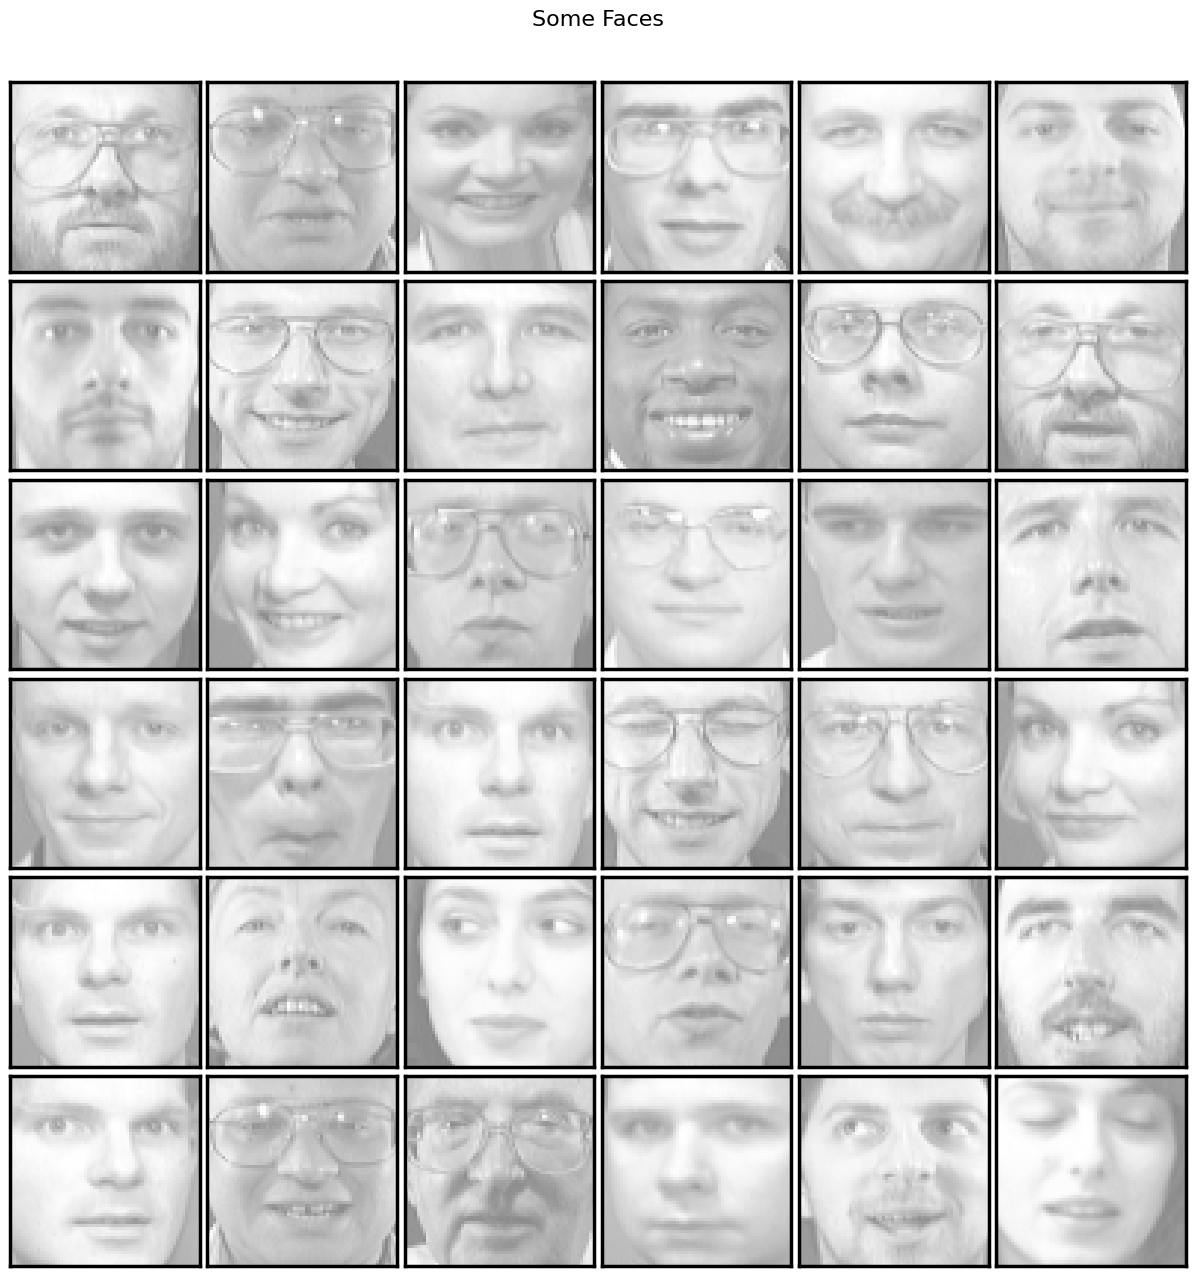

In [3]:
faces = faces.T  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, nrow, ncol, title='', cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = nrow
    ncols = ncol
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    
plot_gallery(title="Some Faces", 
             images=faces[:36], 
             image_shape=image_shape,nrow=6,ncol=6)


### Analysis of the number of components on the reconstruction

#### Reconstruction with Frobenius distance

100%|██████████| 4/4 [00:44<00:00, 11.00s/it]


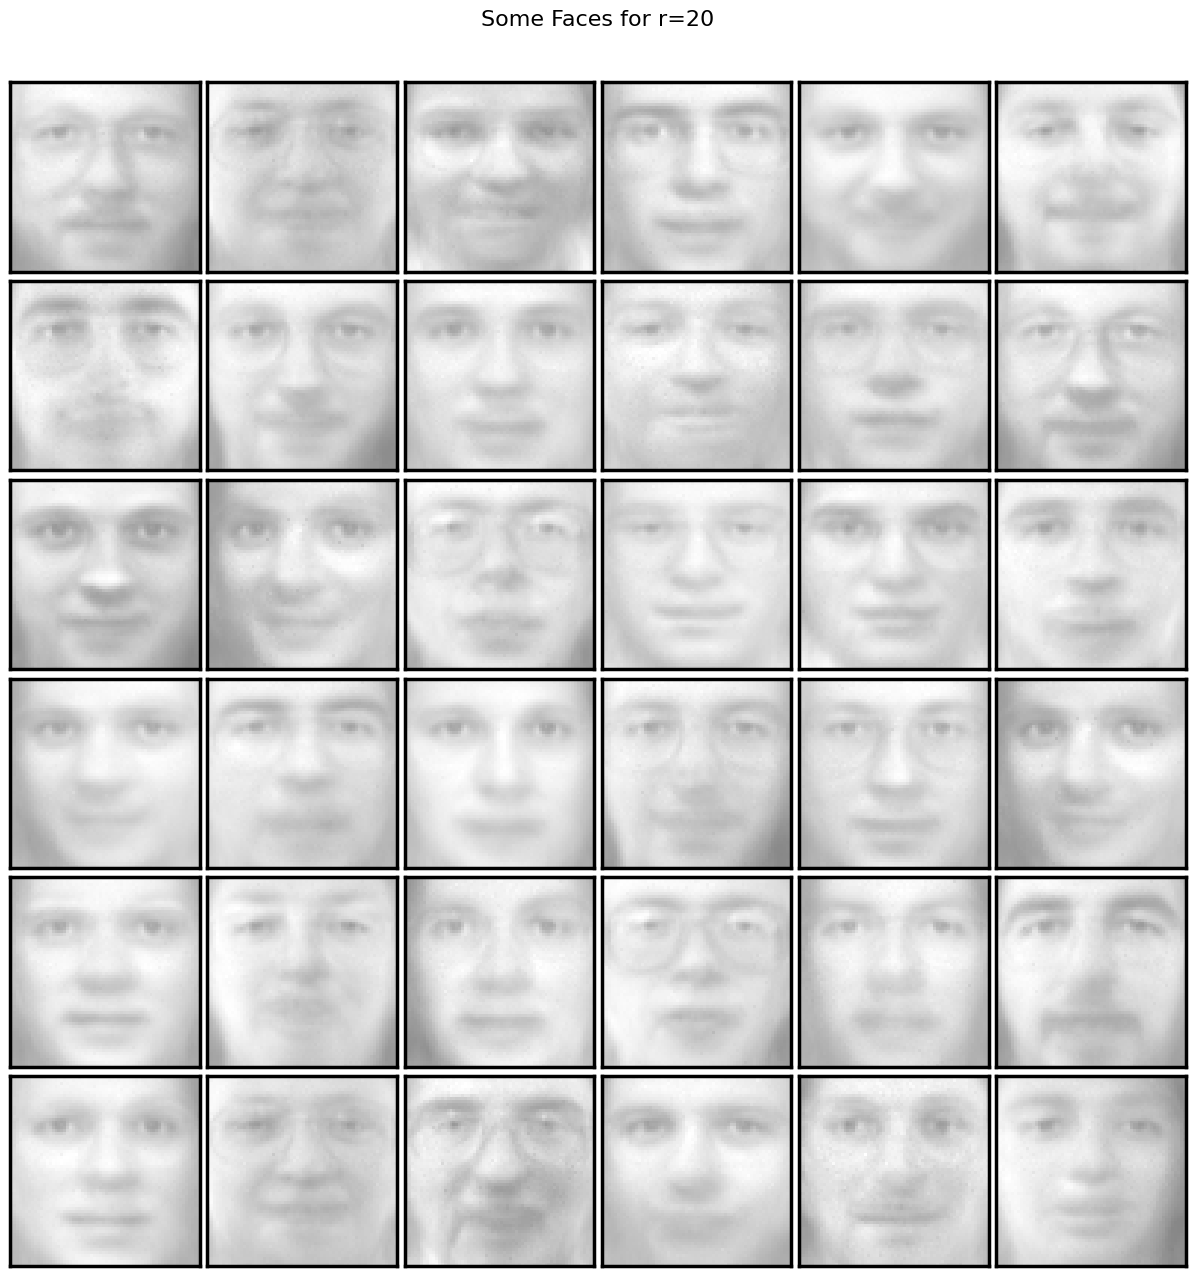

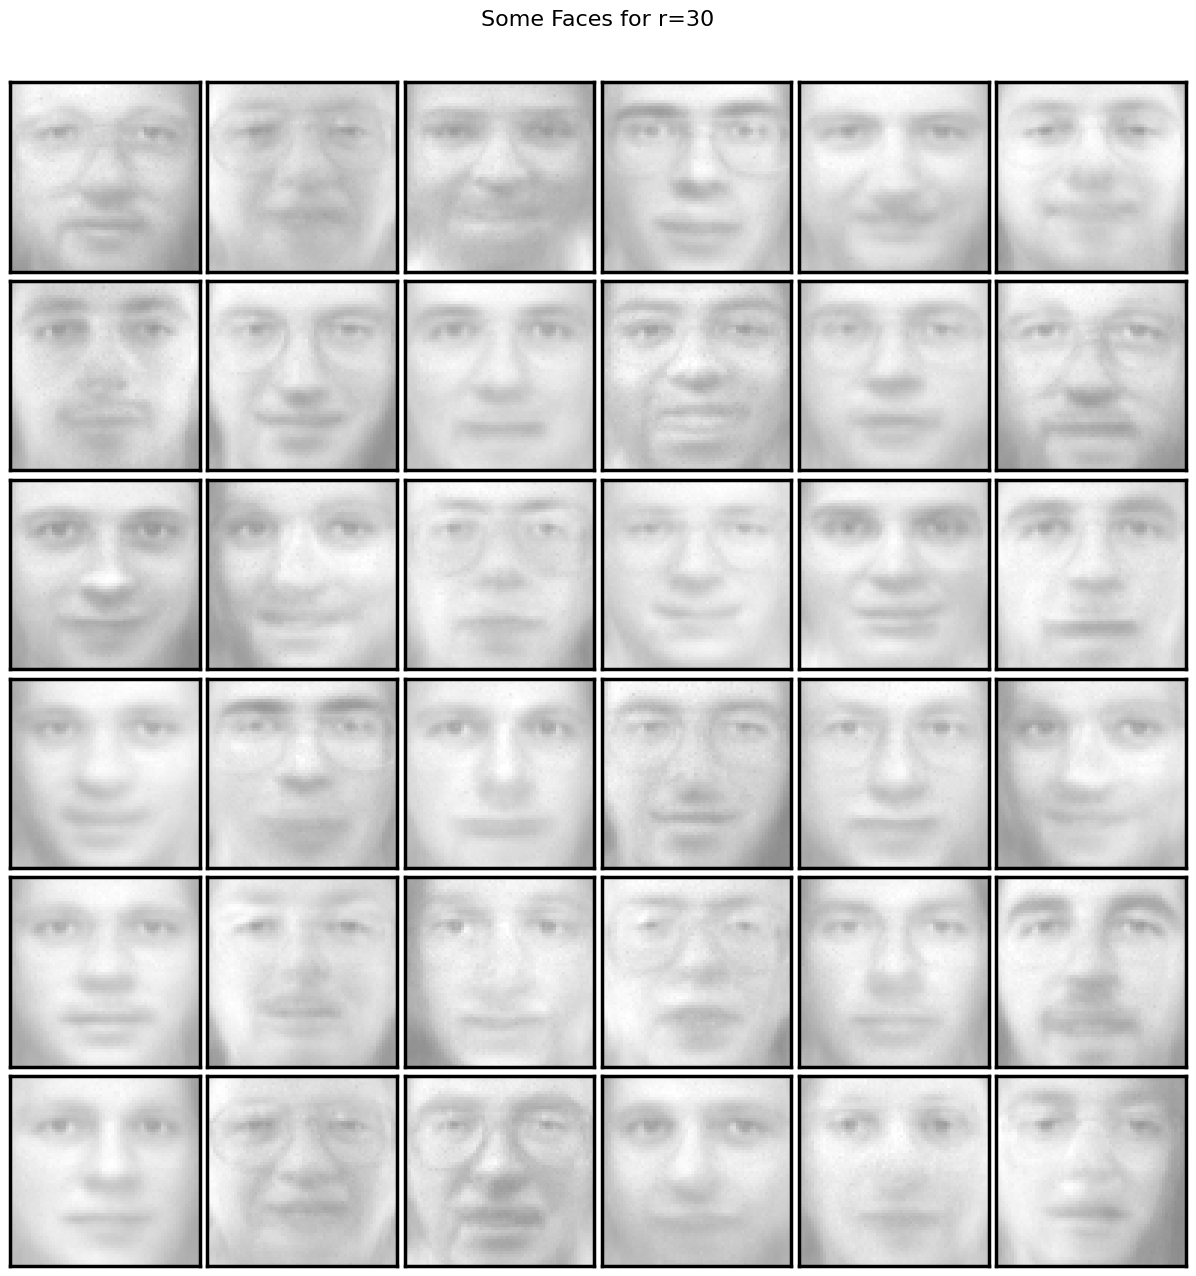

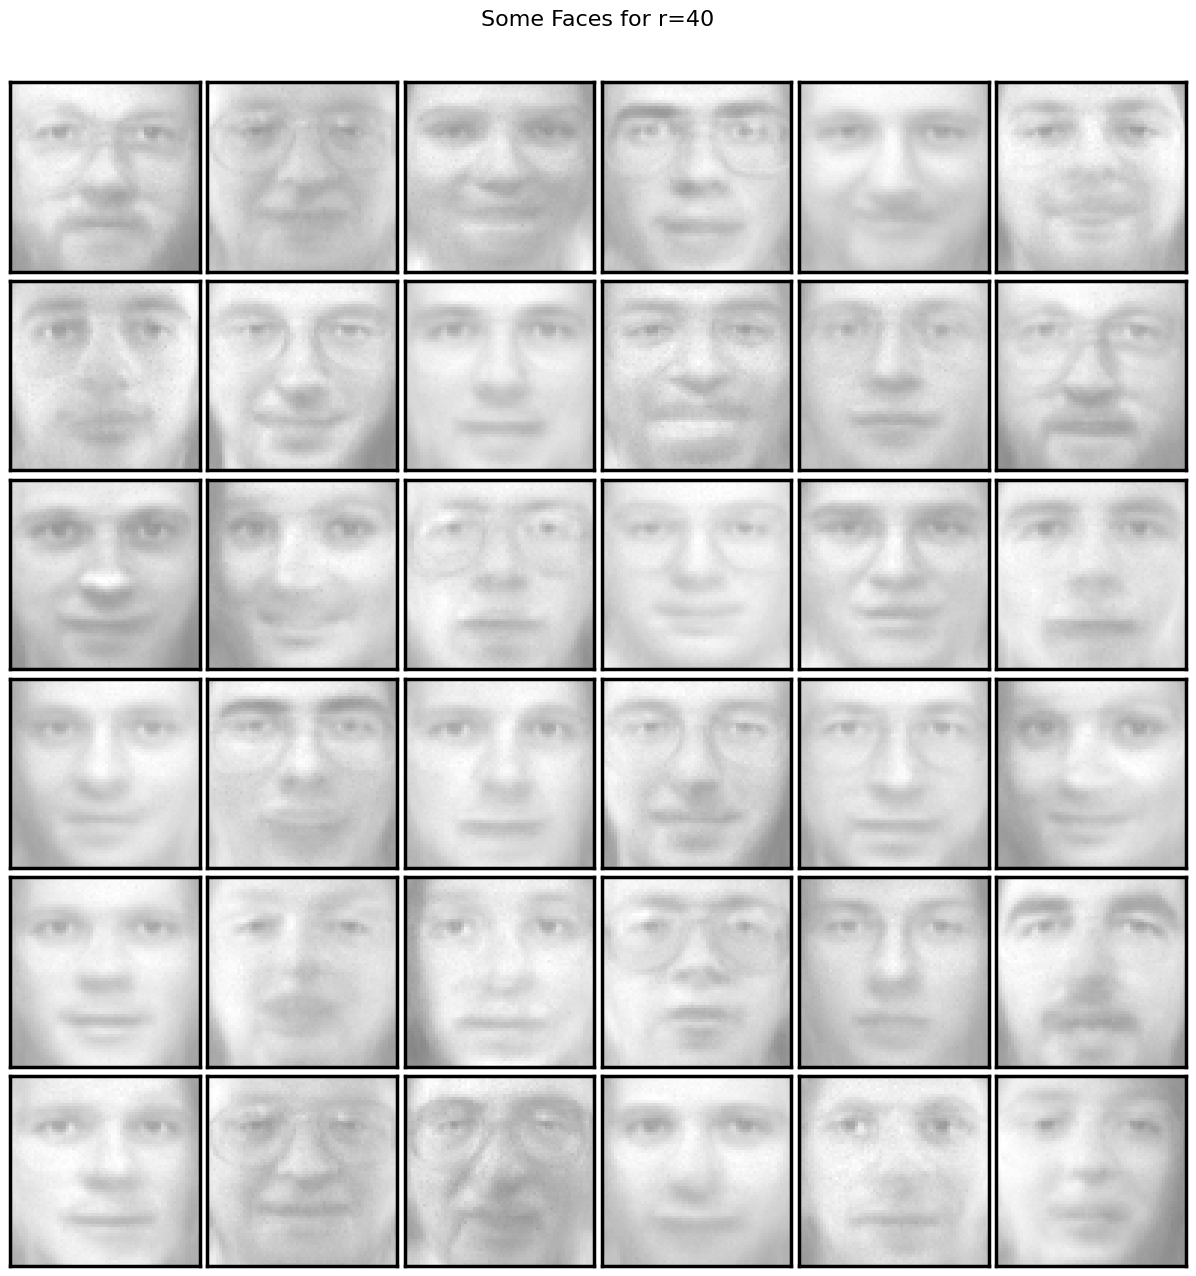

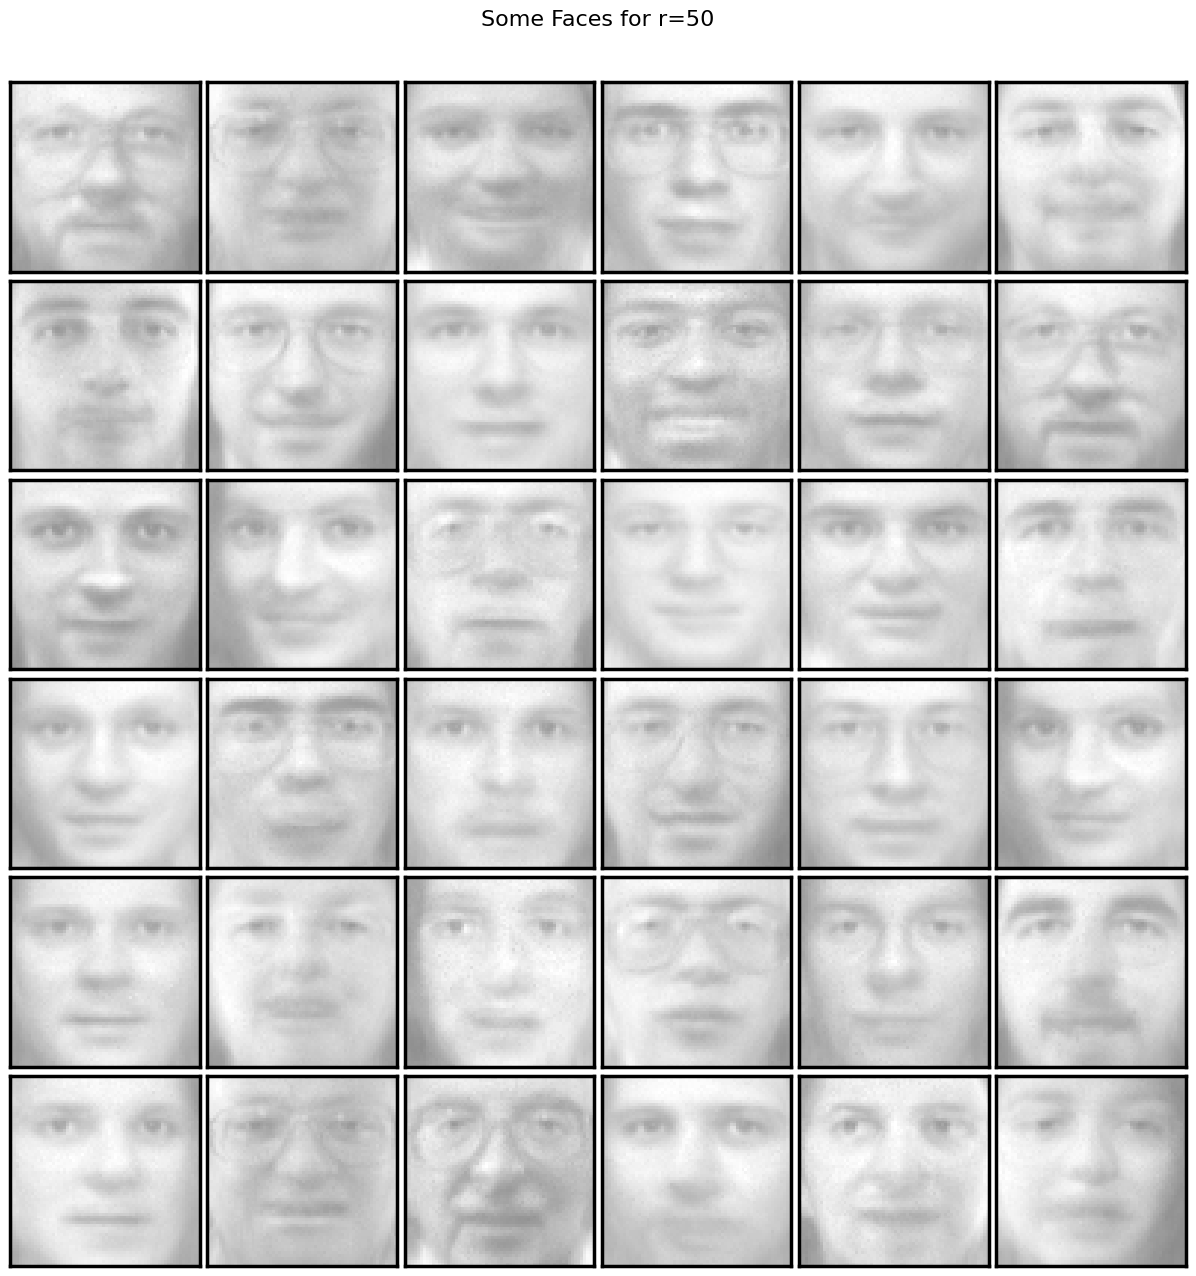

In [42]:
#TODO : plot reconstructed faces for different number of components with Frobenius distance

bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
n_components = range(20, 60, 10)
losses = []

# Plot loss history for each n_component
for n_component in tqdm(n_components):
    nmf = MYNMF(max_iter=200, n_components=n_component)
    nmf.fit_transform(faces.T, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
    reconstructed_data = nmf.D_ @ nmf.S_
    plot_gallery(title=f"Some Faces for r={n_component}", 
             images=reconstructed_data.T[:36], 
             image_shape=image_shape,nrow=6,ncol=6)

#### Reconstruction with Kullback-Leibler divergence

100%|██████████| 4/4 [02:09<00:00, 32.36s/it]


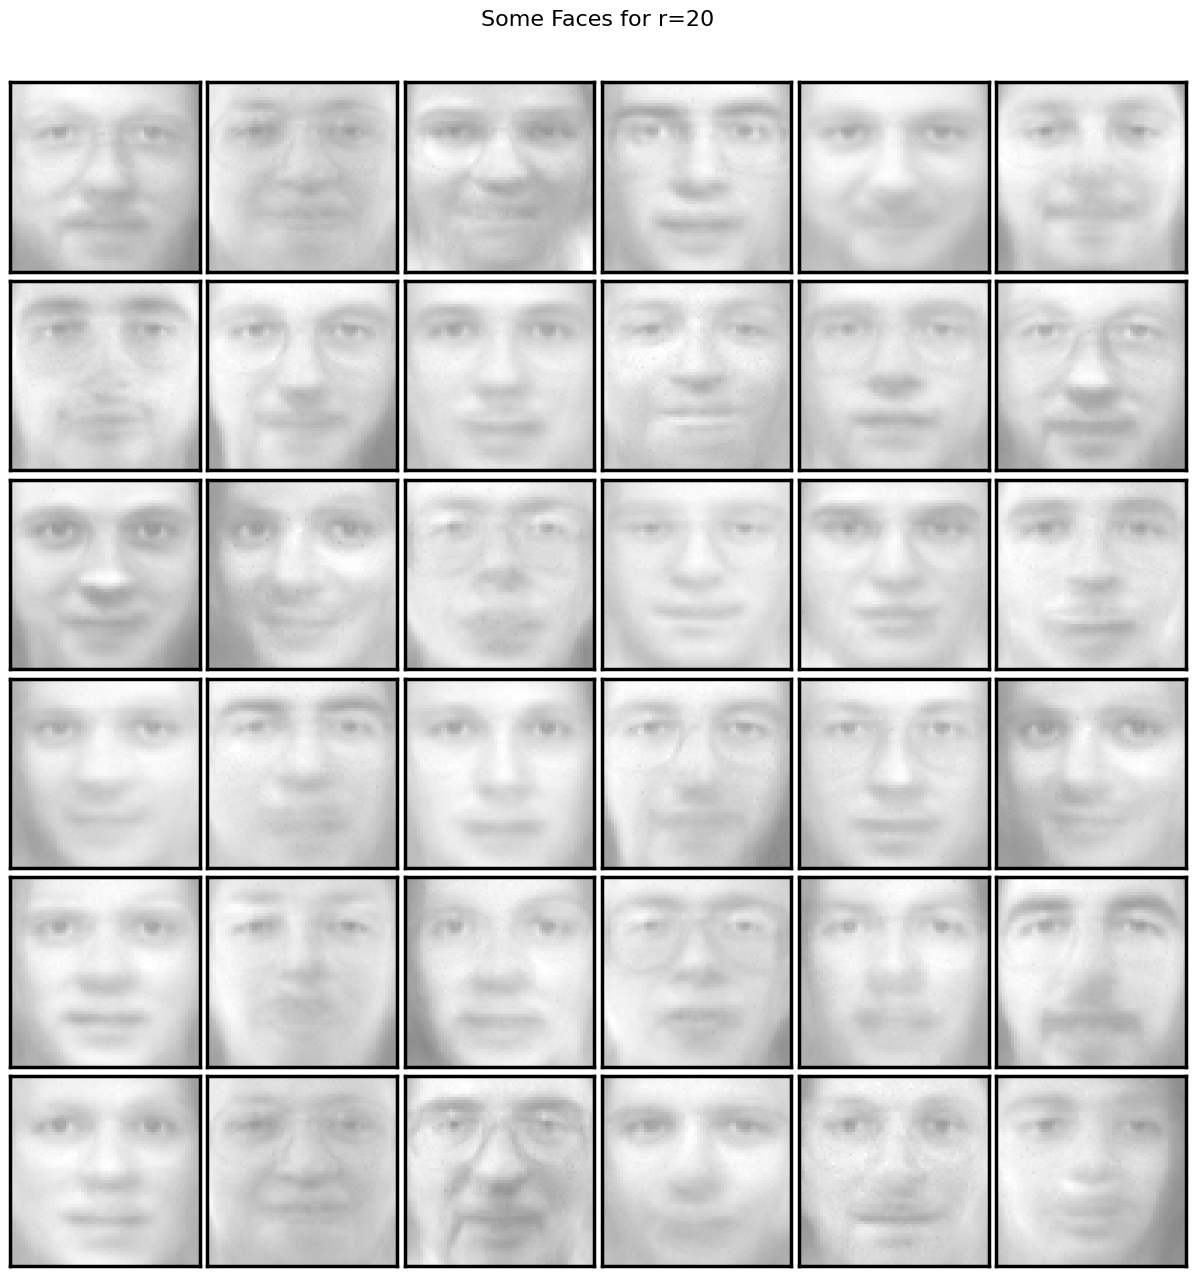

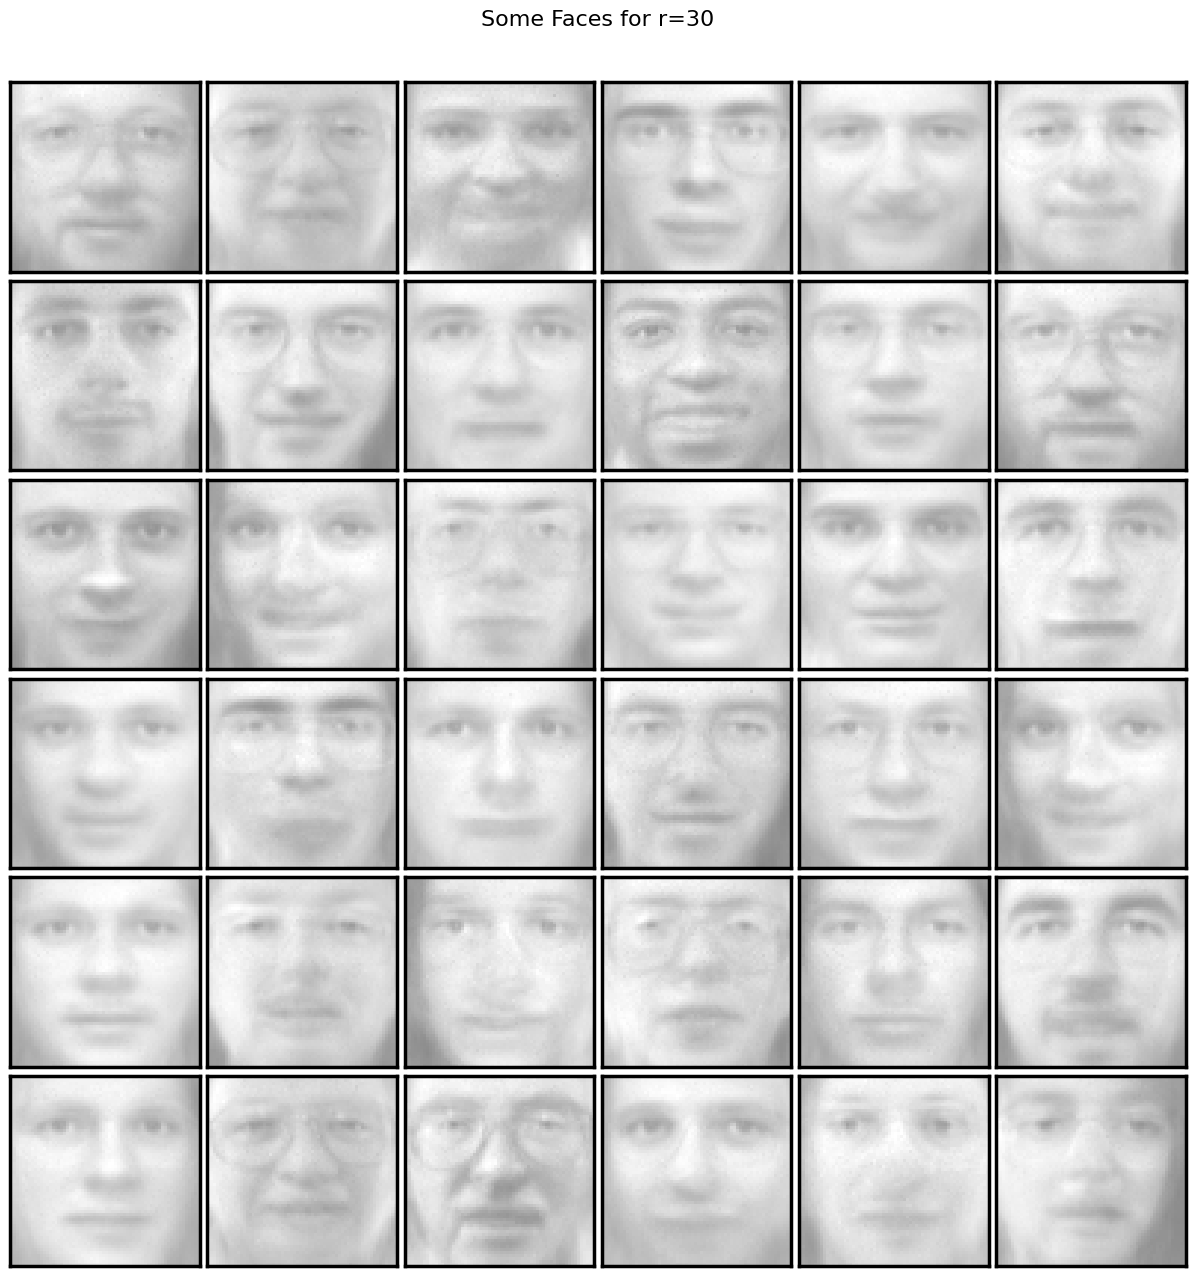

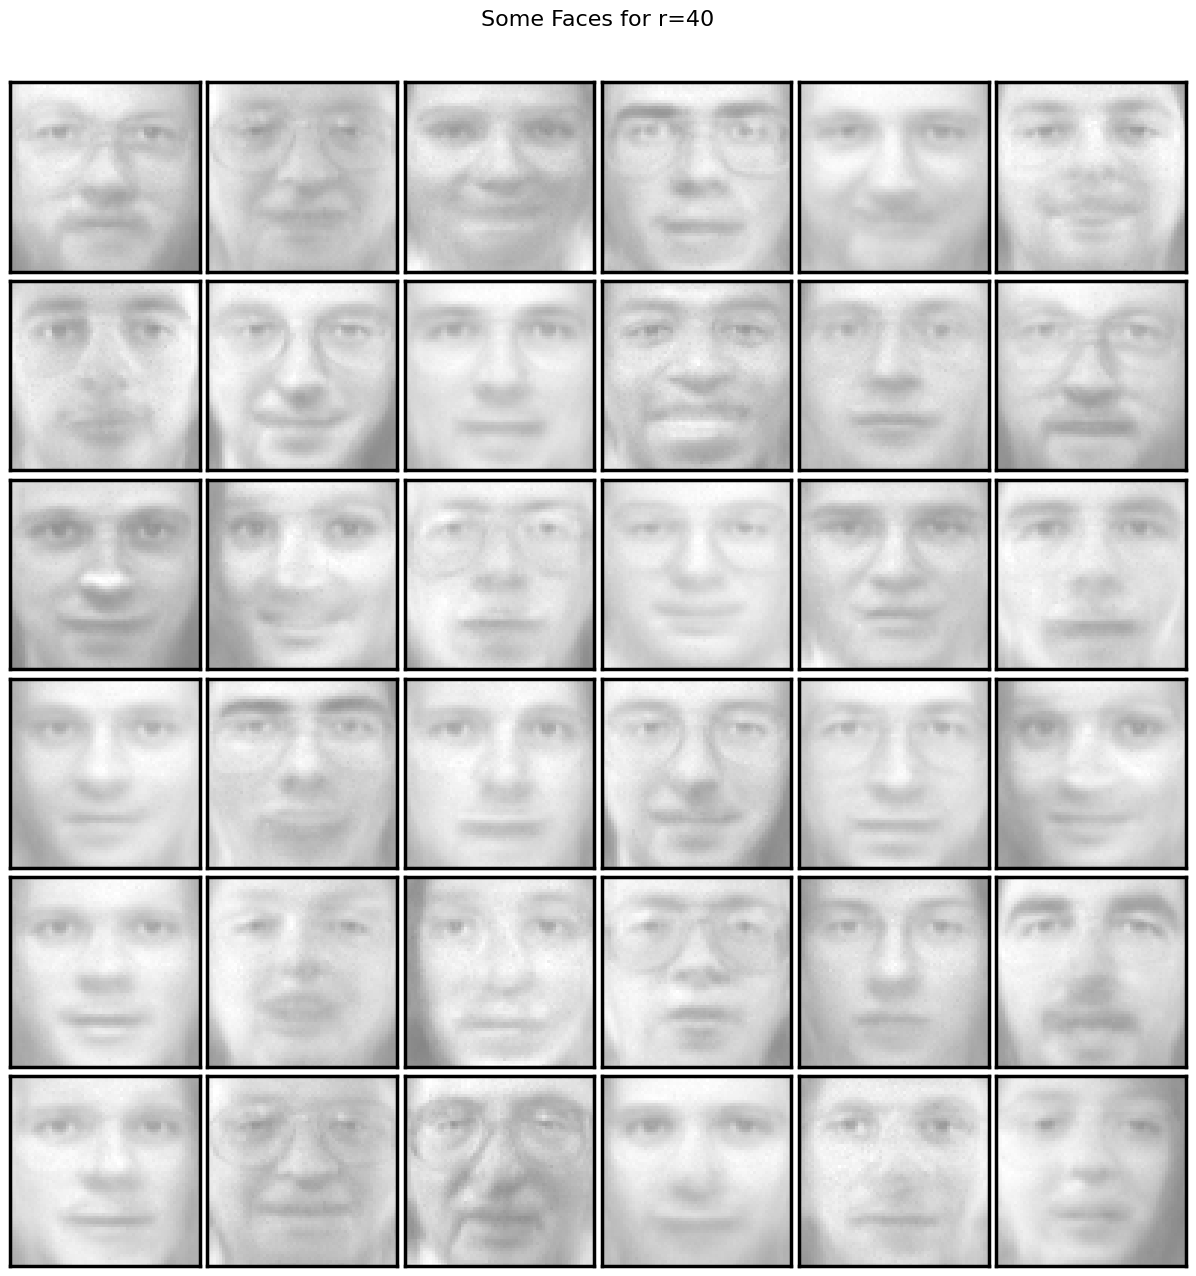

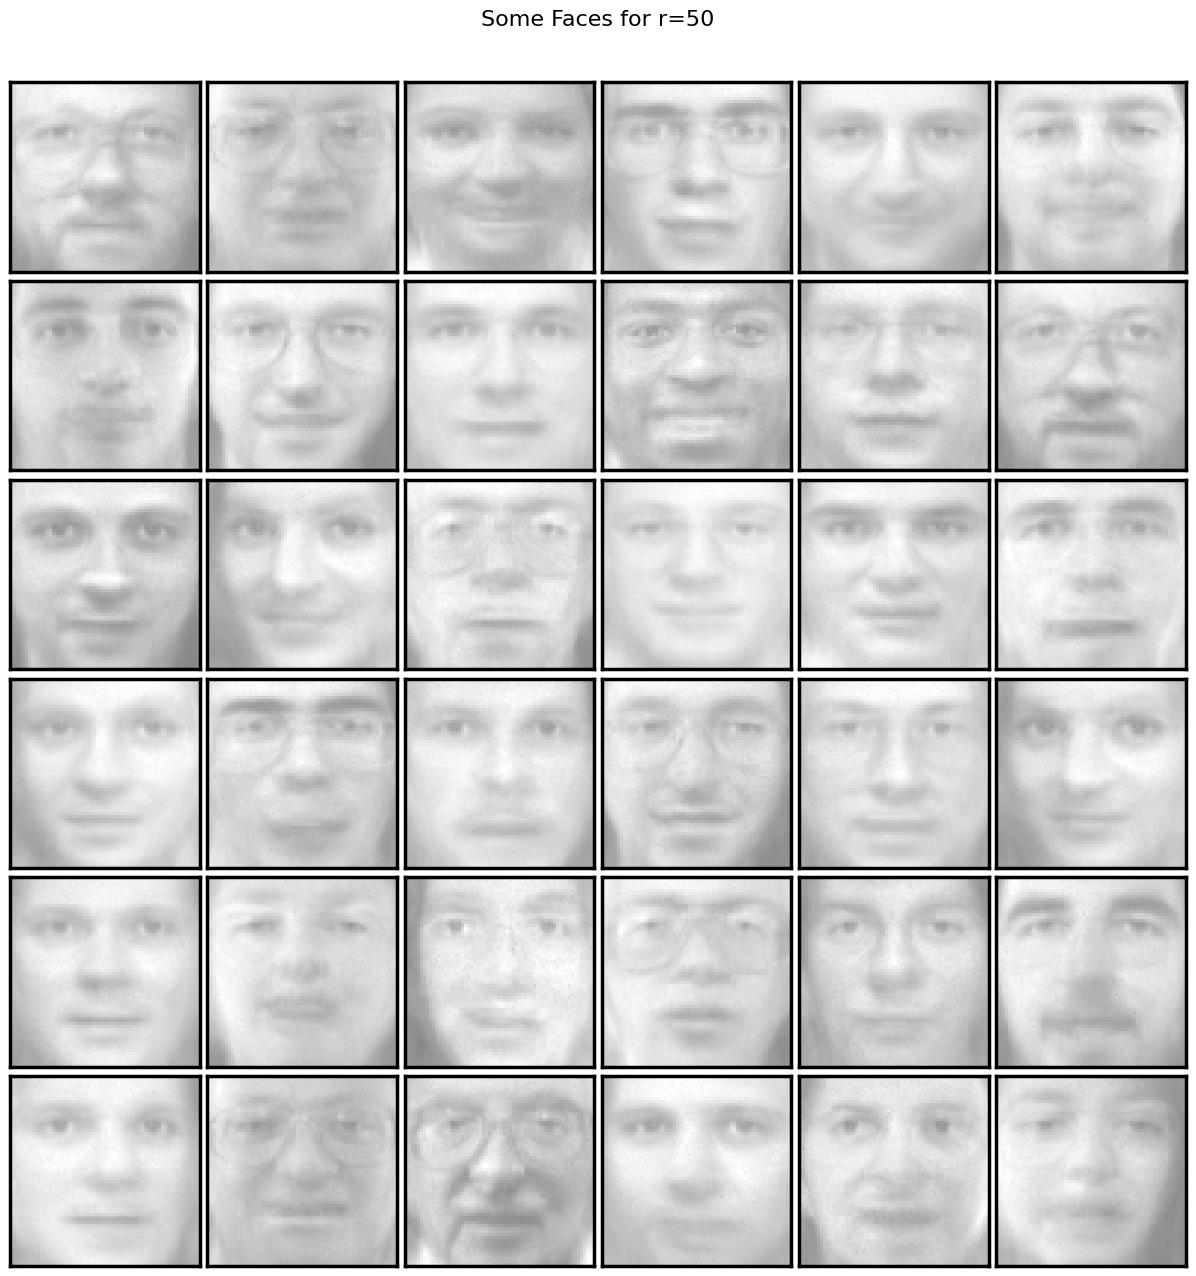

In [43]:
#TODO : plot reconstructed faces for different number of components with KL divergence

bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
n_components = range(20, 60, 10)
losses = []

# Plot loss history for each n_component
for n_component in tqdm(n_components):
    nmf = MYNMF(max_iter=200, loss='KL', n_components=n_component)
    nmf.fit_transform(faces.T, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
    reconstructed_data = nmf.D_ @ nmf.S_
    plot_gallery(title=f"Some Faces for r={n_component}", 
             images=reconstructed_data.T[:36], 
             image_shape=image_shape,nrow=6,ncol=6)

There is not much difference between the reconstructed faces using Frobenius Distance and that with KL distance.

#### Comparison of the elements of the dictionary between the two distances

100%|██████████| 4/4 [01:40<00:00, 25.12s/it]


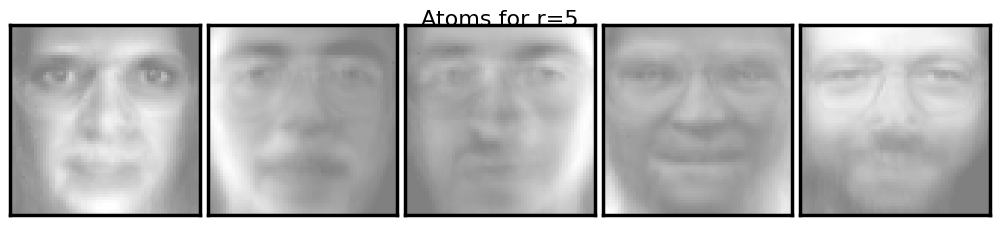

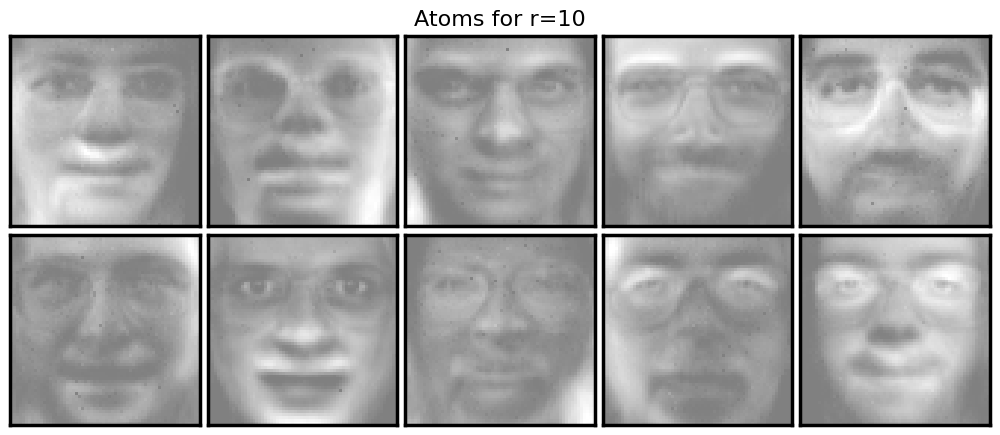

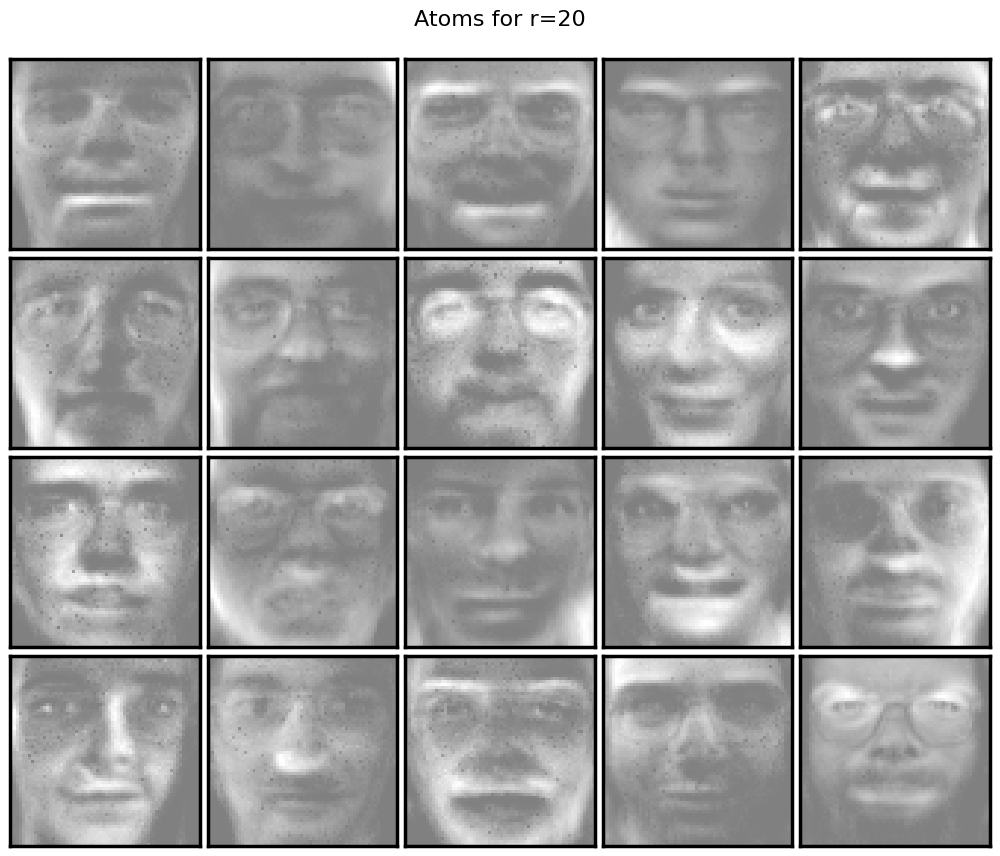

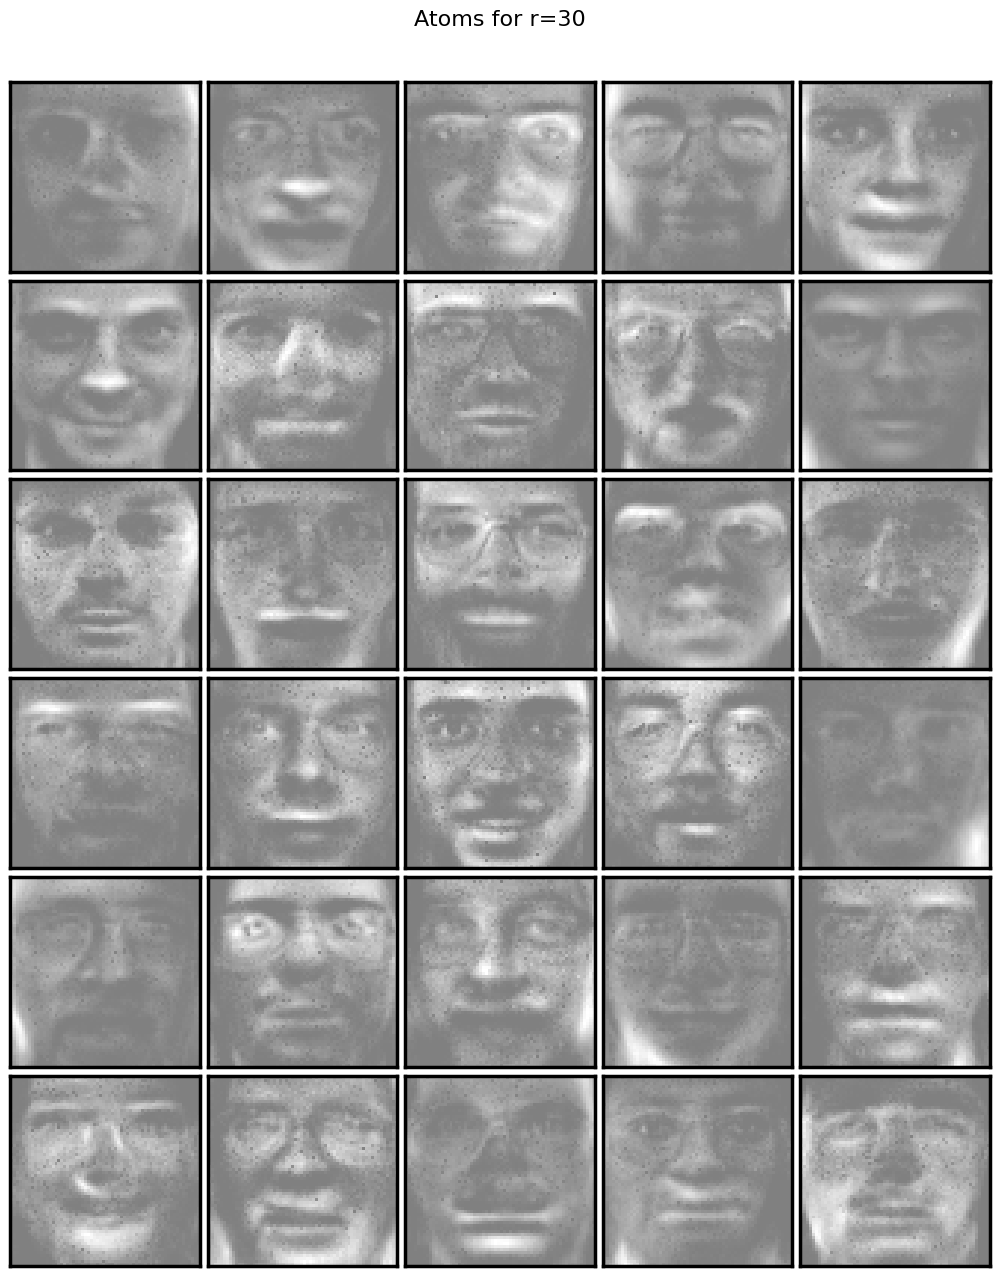

In [47]:
#TODO : plot the atoms of the dictionary for various number of components

bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
n_components = [5, 10, 20, 30]
losses = []

# Plot loss history for each n_component
for n_component in tqdm(n_components):
    nmf = MYNMF(max_iter=200, loss='KL', n_components=n_component)
    nmf.fit_transform(faces.T, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
    plot_gallery(title=f"Atoms for r={n_component}", 
             images=nmf.D_.T[:n_component], 
             image_shape=image_shape, nrow=n_component//5, ncol=5)

### Study of the clustering for the Frobenius distance with 30 components

Now, we are going to clusterise the images in r different classes. First, we start by normalizing the norm of the dictionary elements, so that the euclidian norm = 1, and we multiply the associated row in the S matrix to preserve the factorization DS = X. Then, we find the highest coefficient for each image, and we use the index of the maximum as clustering label.

In [4]:
#TODO : Study the clustering
bst_mu = 1e-4
bst_nu = 1e-4
bst_lambd = 1e-6
n_component = 30
losses = []


nmf = MYNMF(max_iter=200, n_components=n_component)
nmf.fit_transform(faces.T, mu=bst_mu, nu=bst_nu, lambd=bst_lambd)
norm = np.linalg.norm(nmf.D_)
nmf.D_ = nmf.D_ / norm
nmf.S_ = nmf.S_ * norm
clusters = nmf.predict_label(faces)

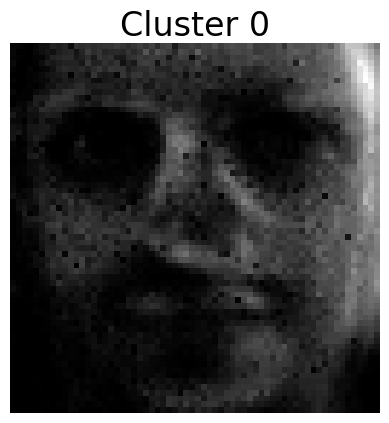

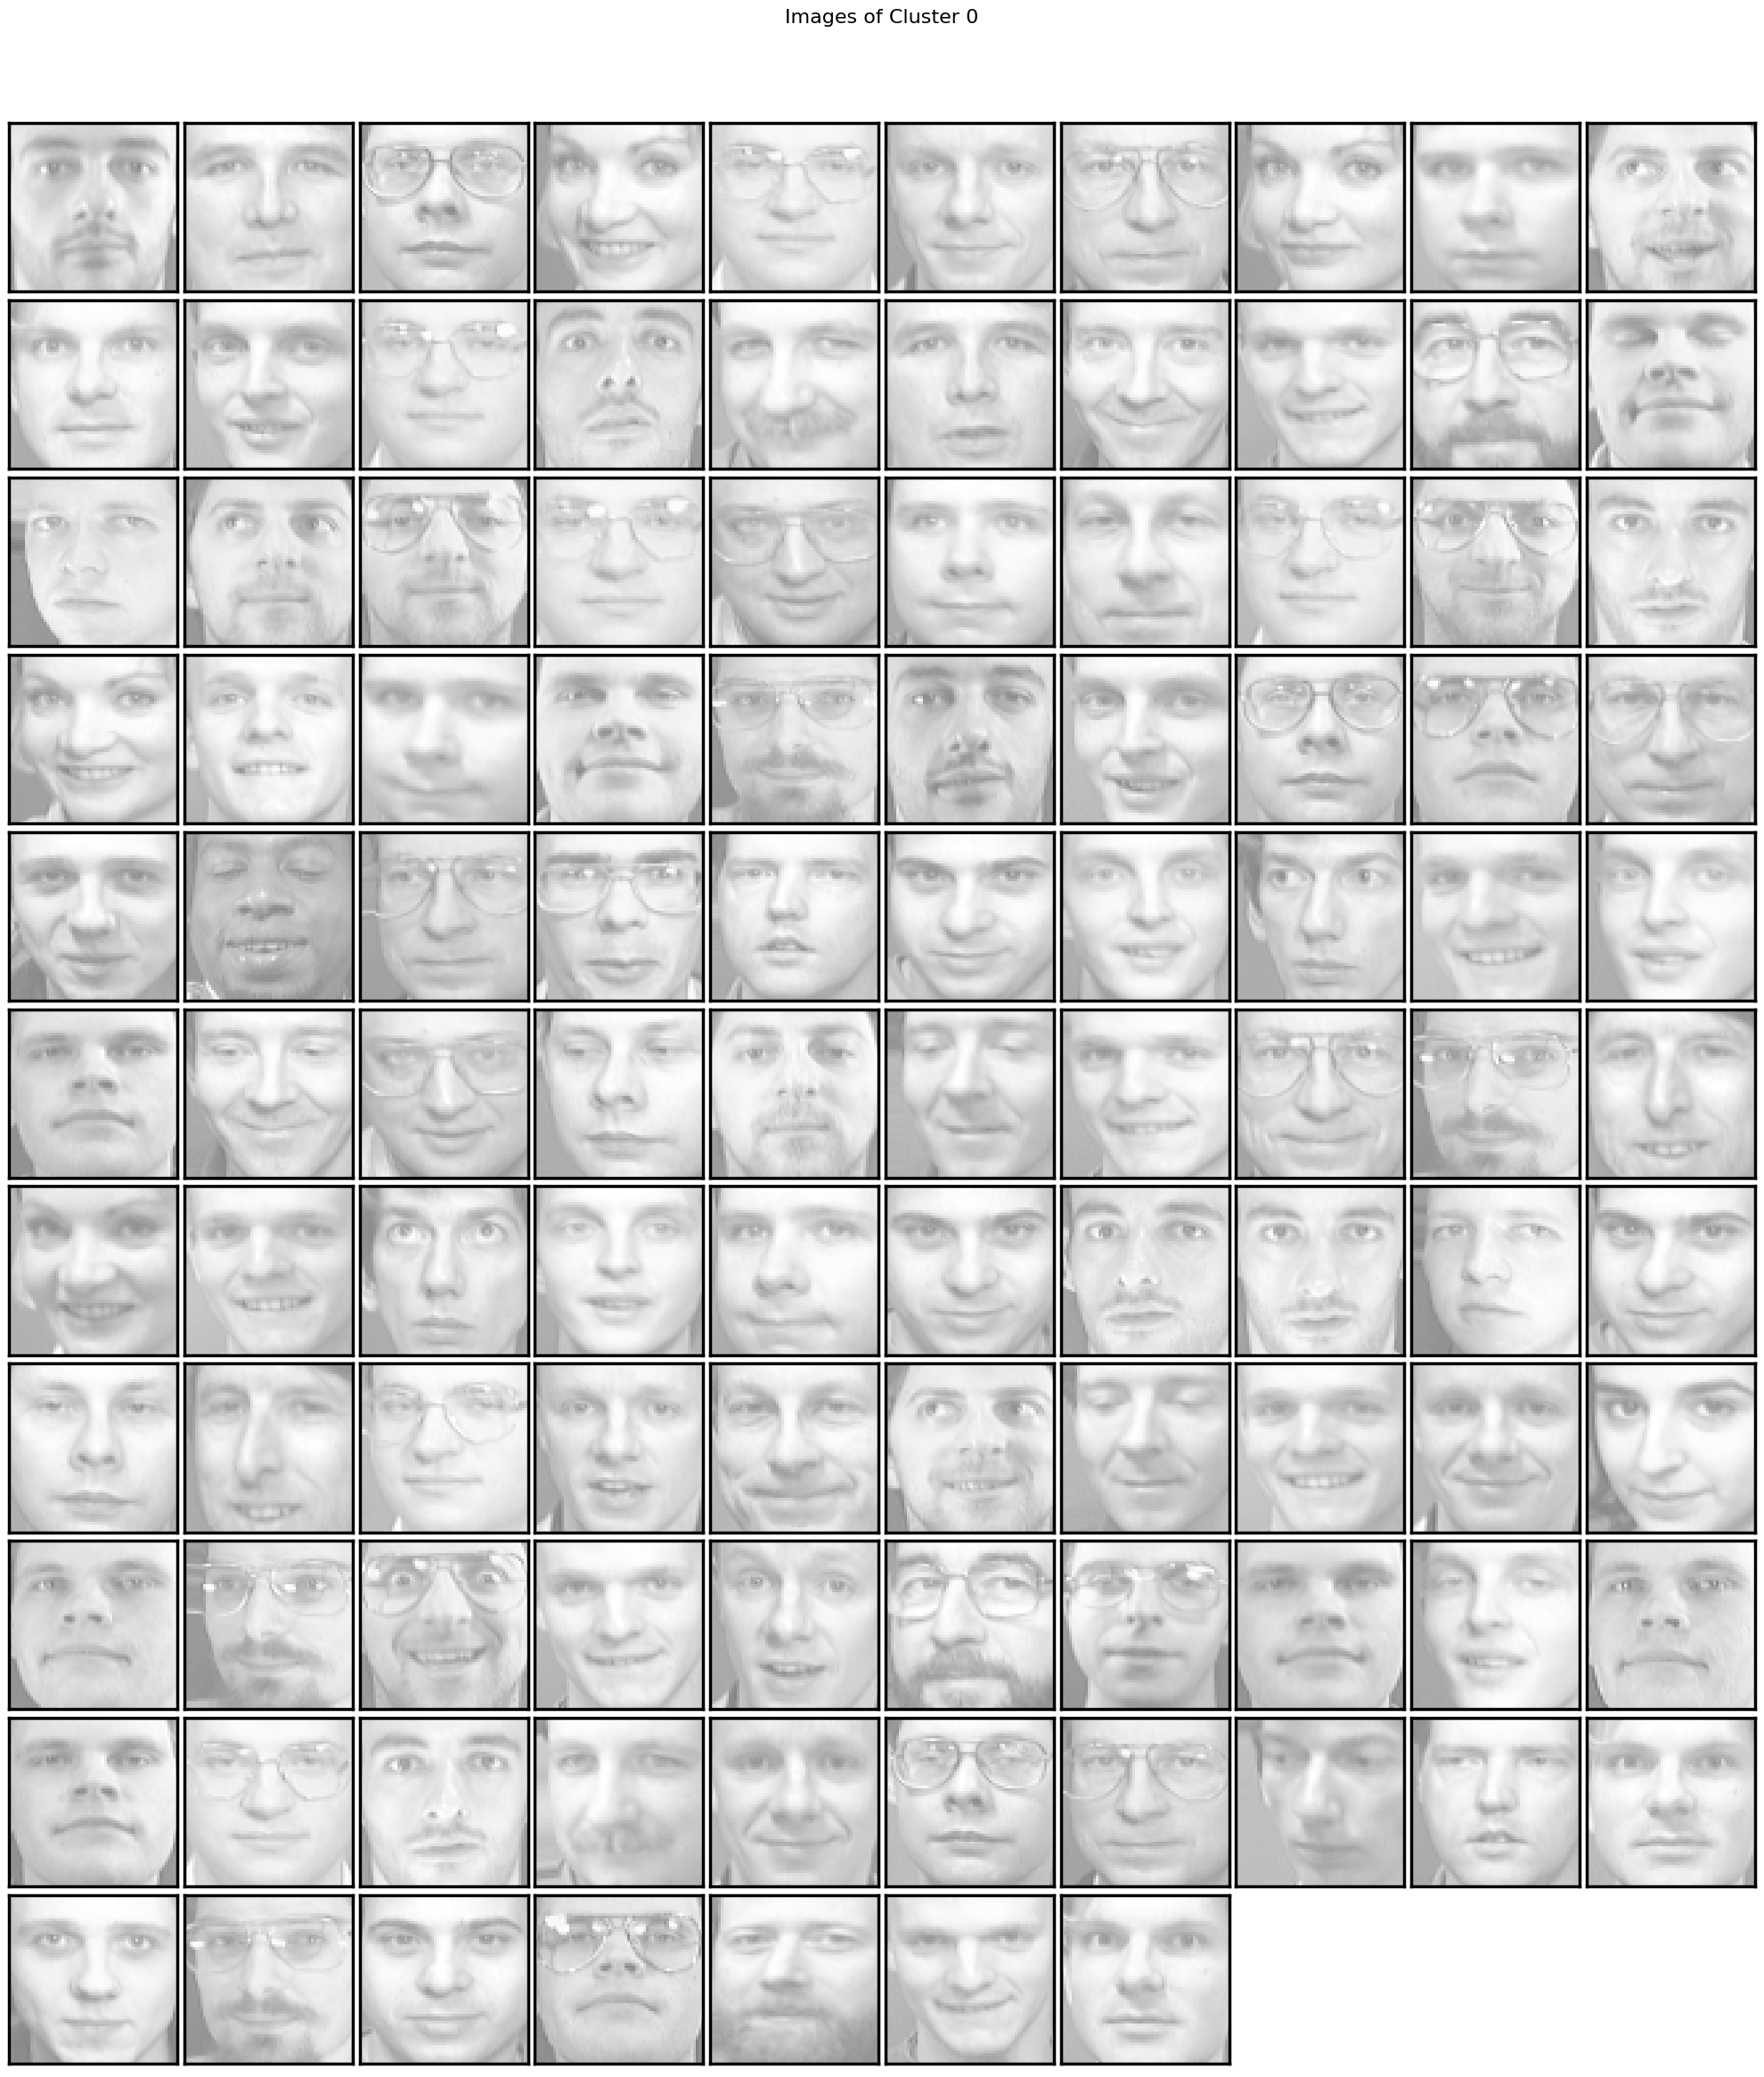

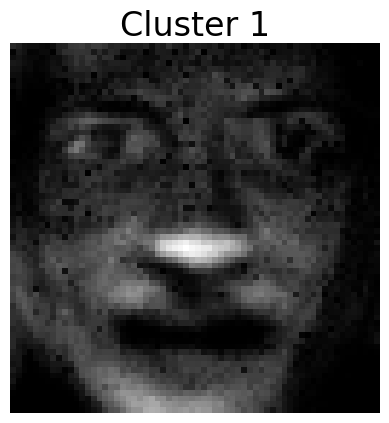

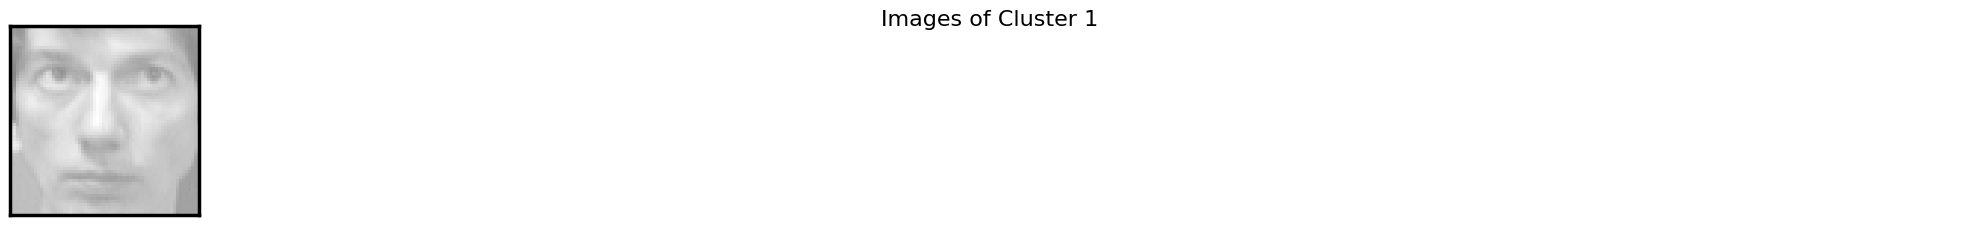

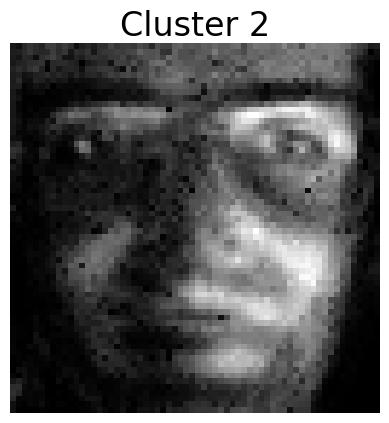

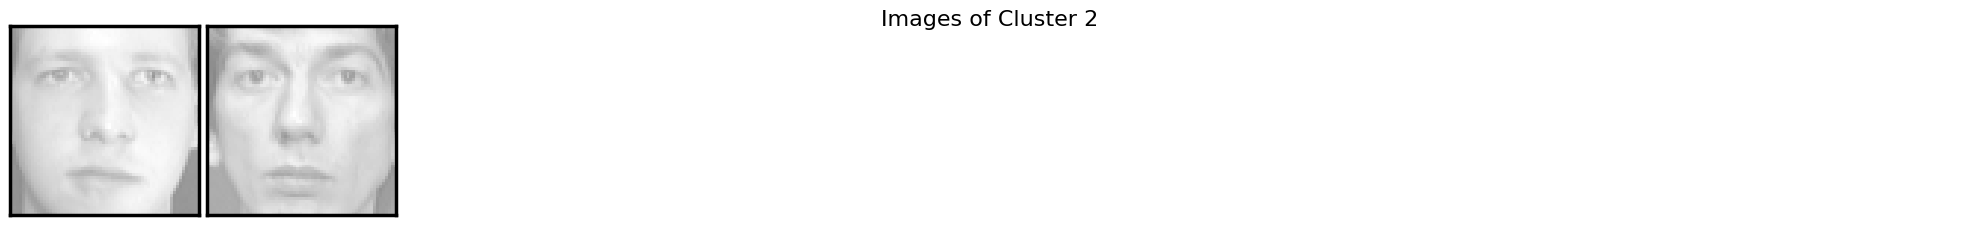

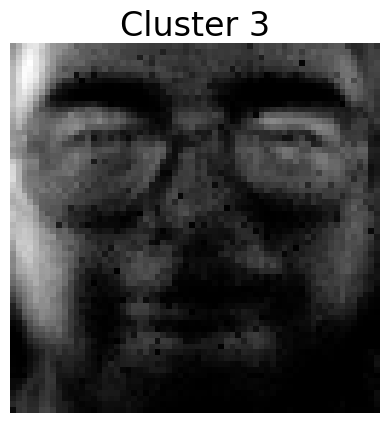

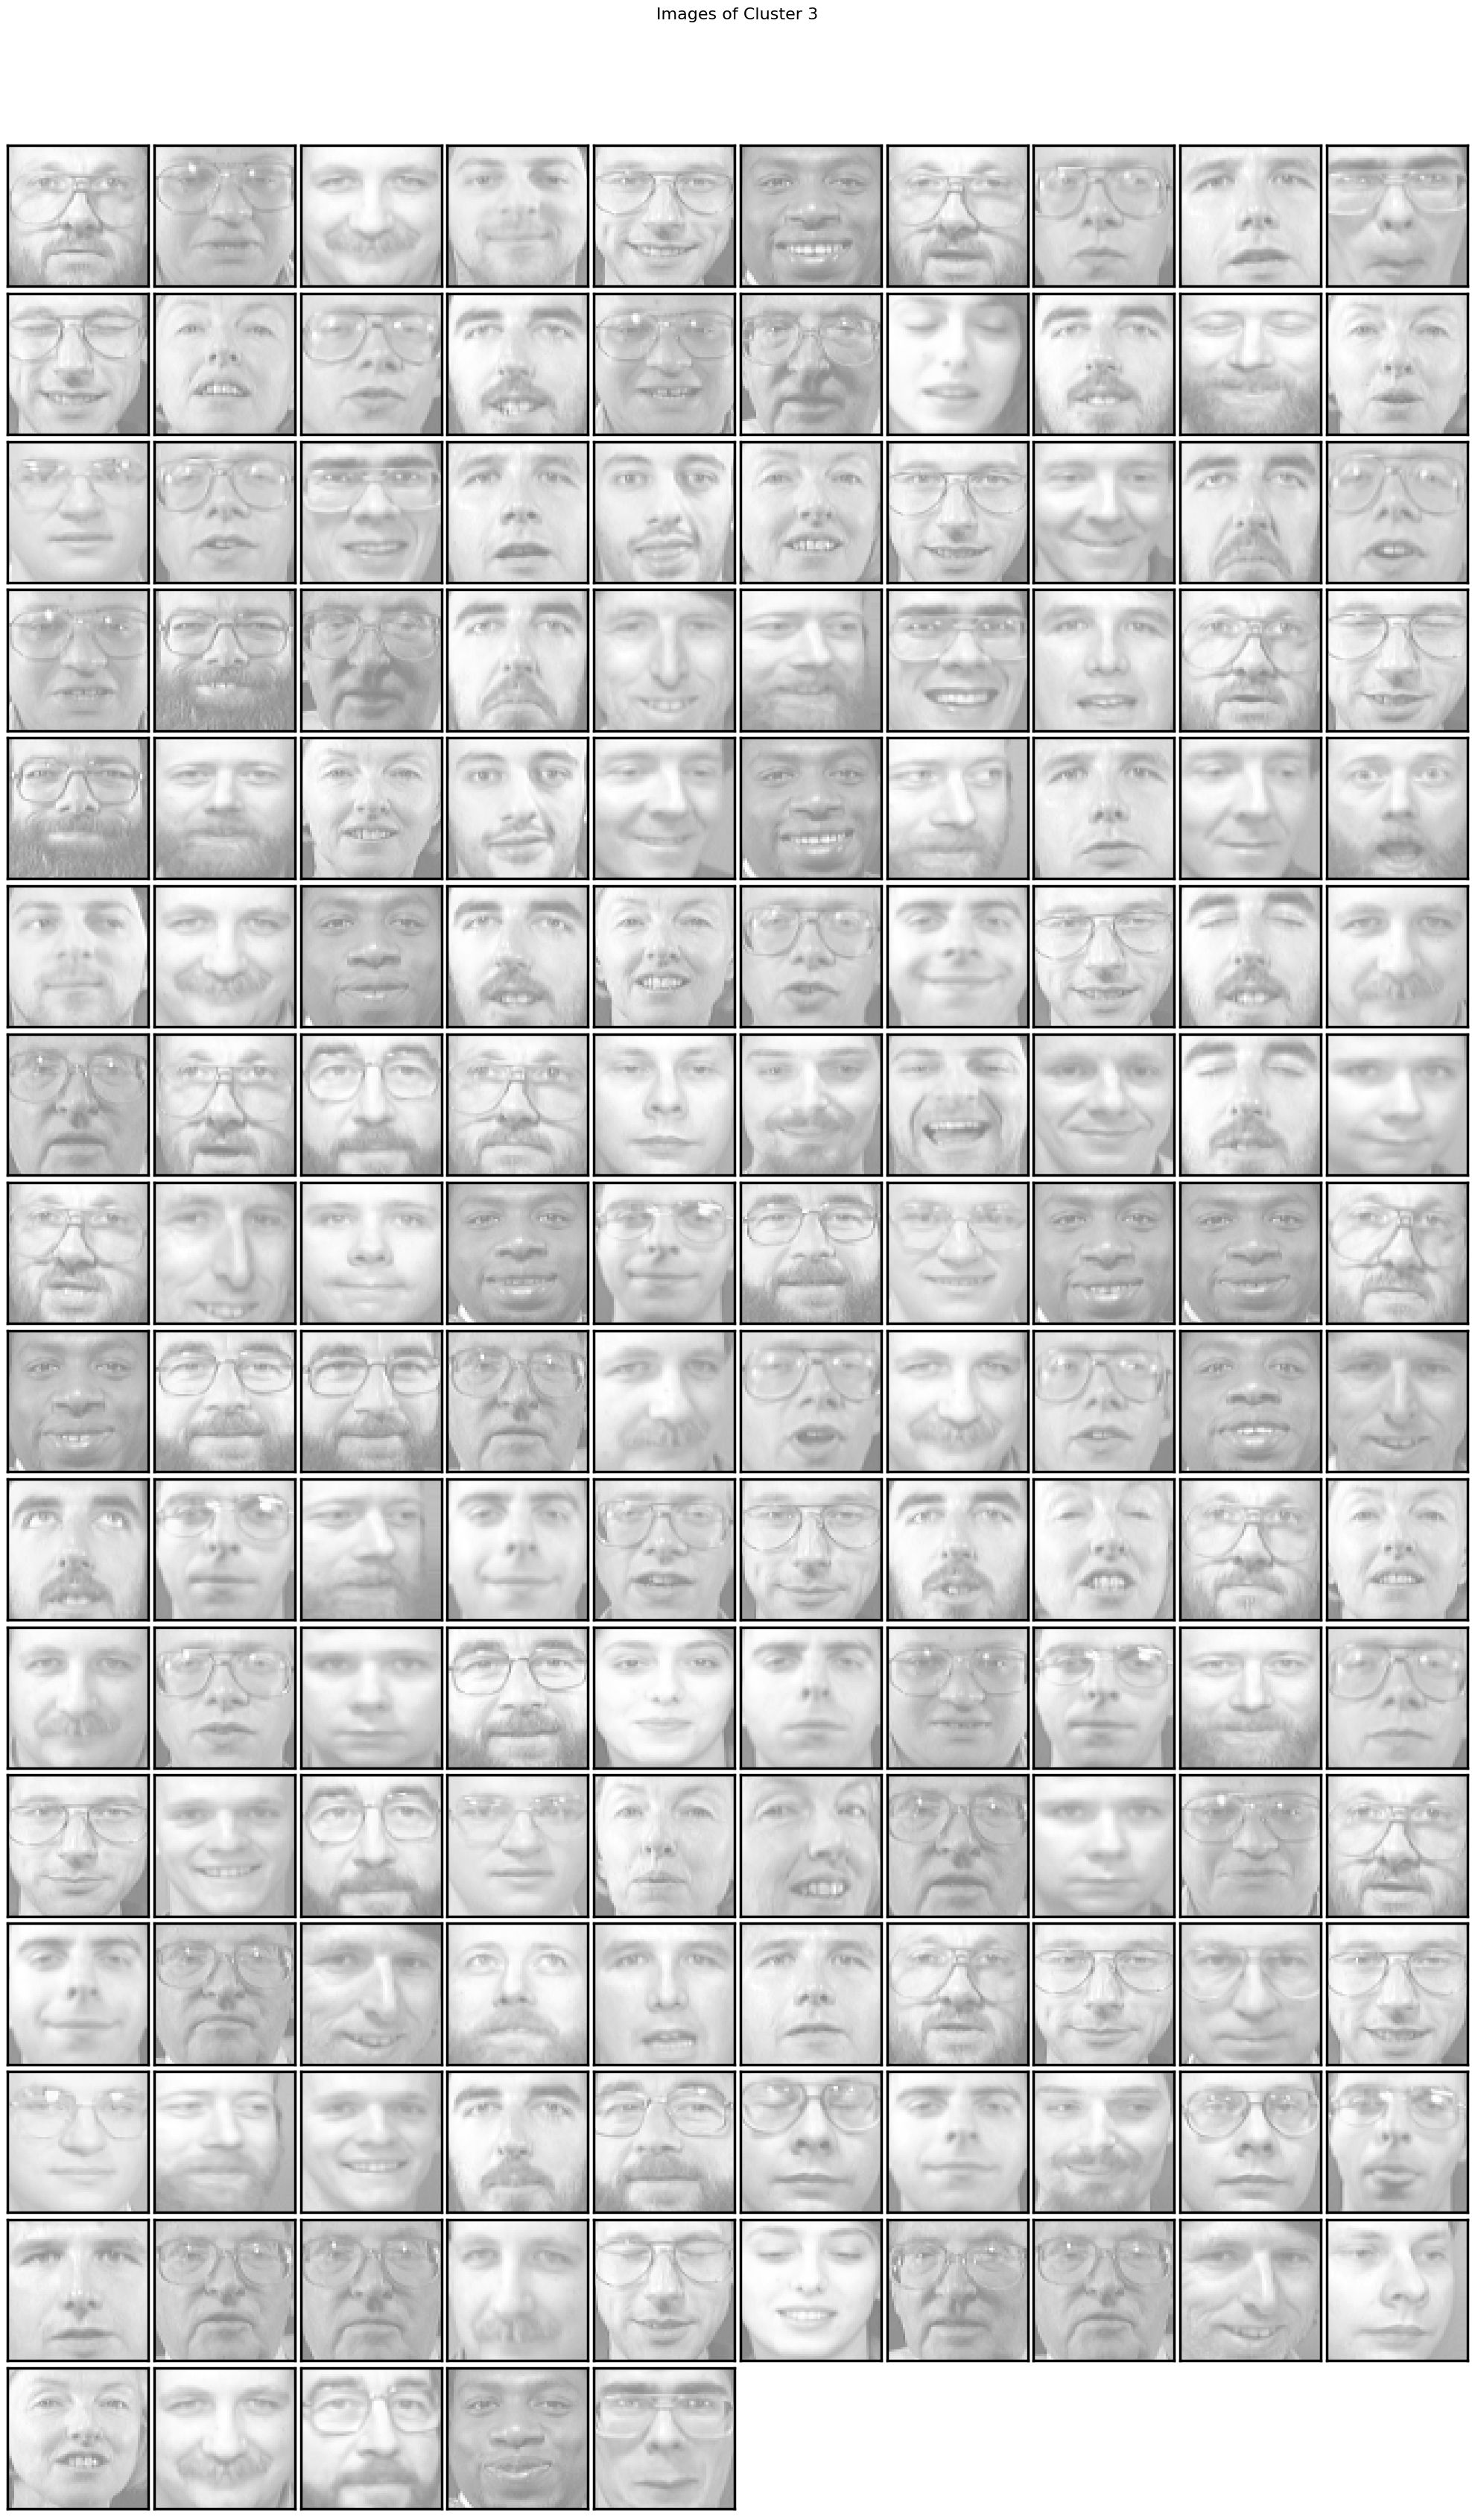

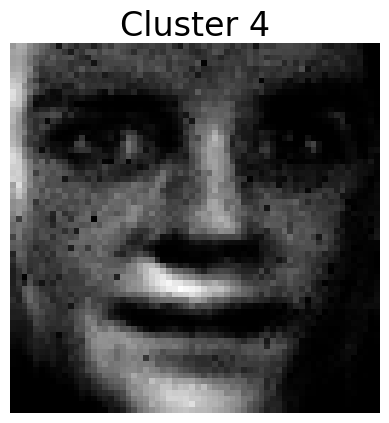

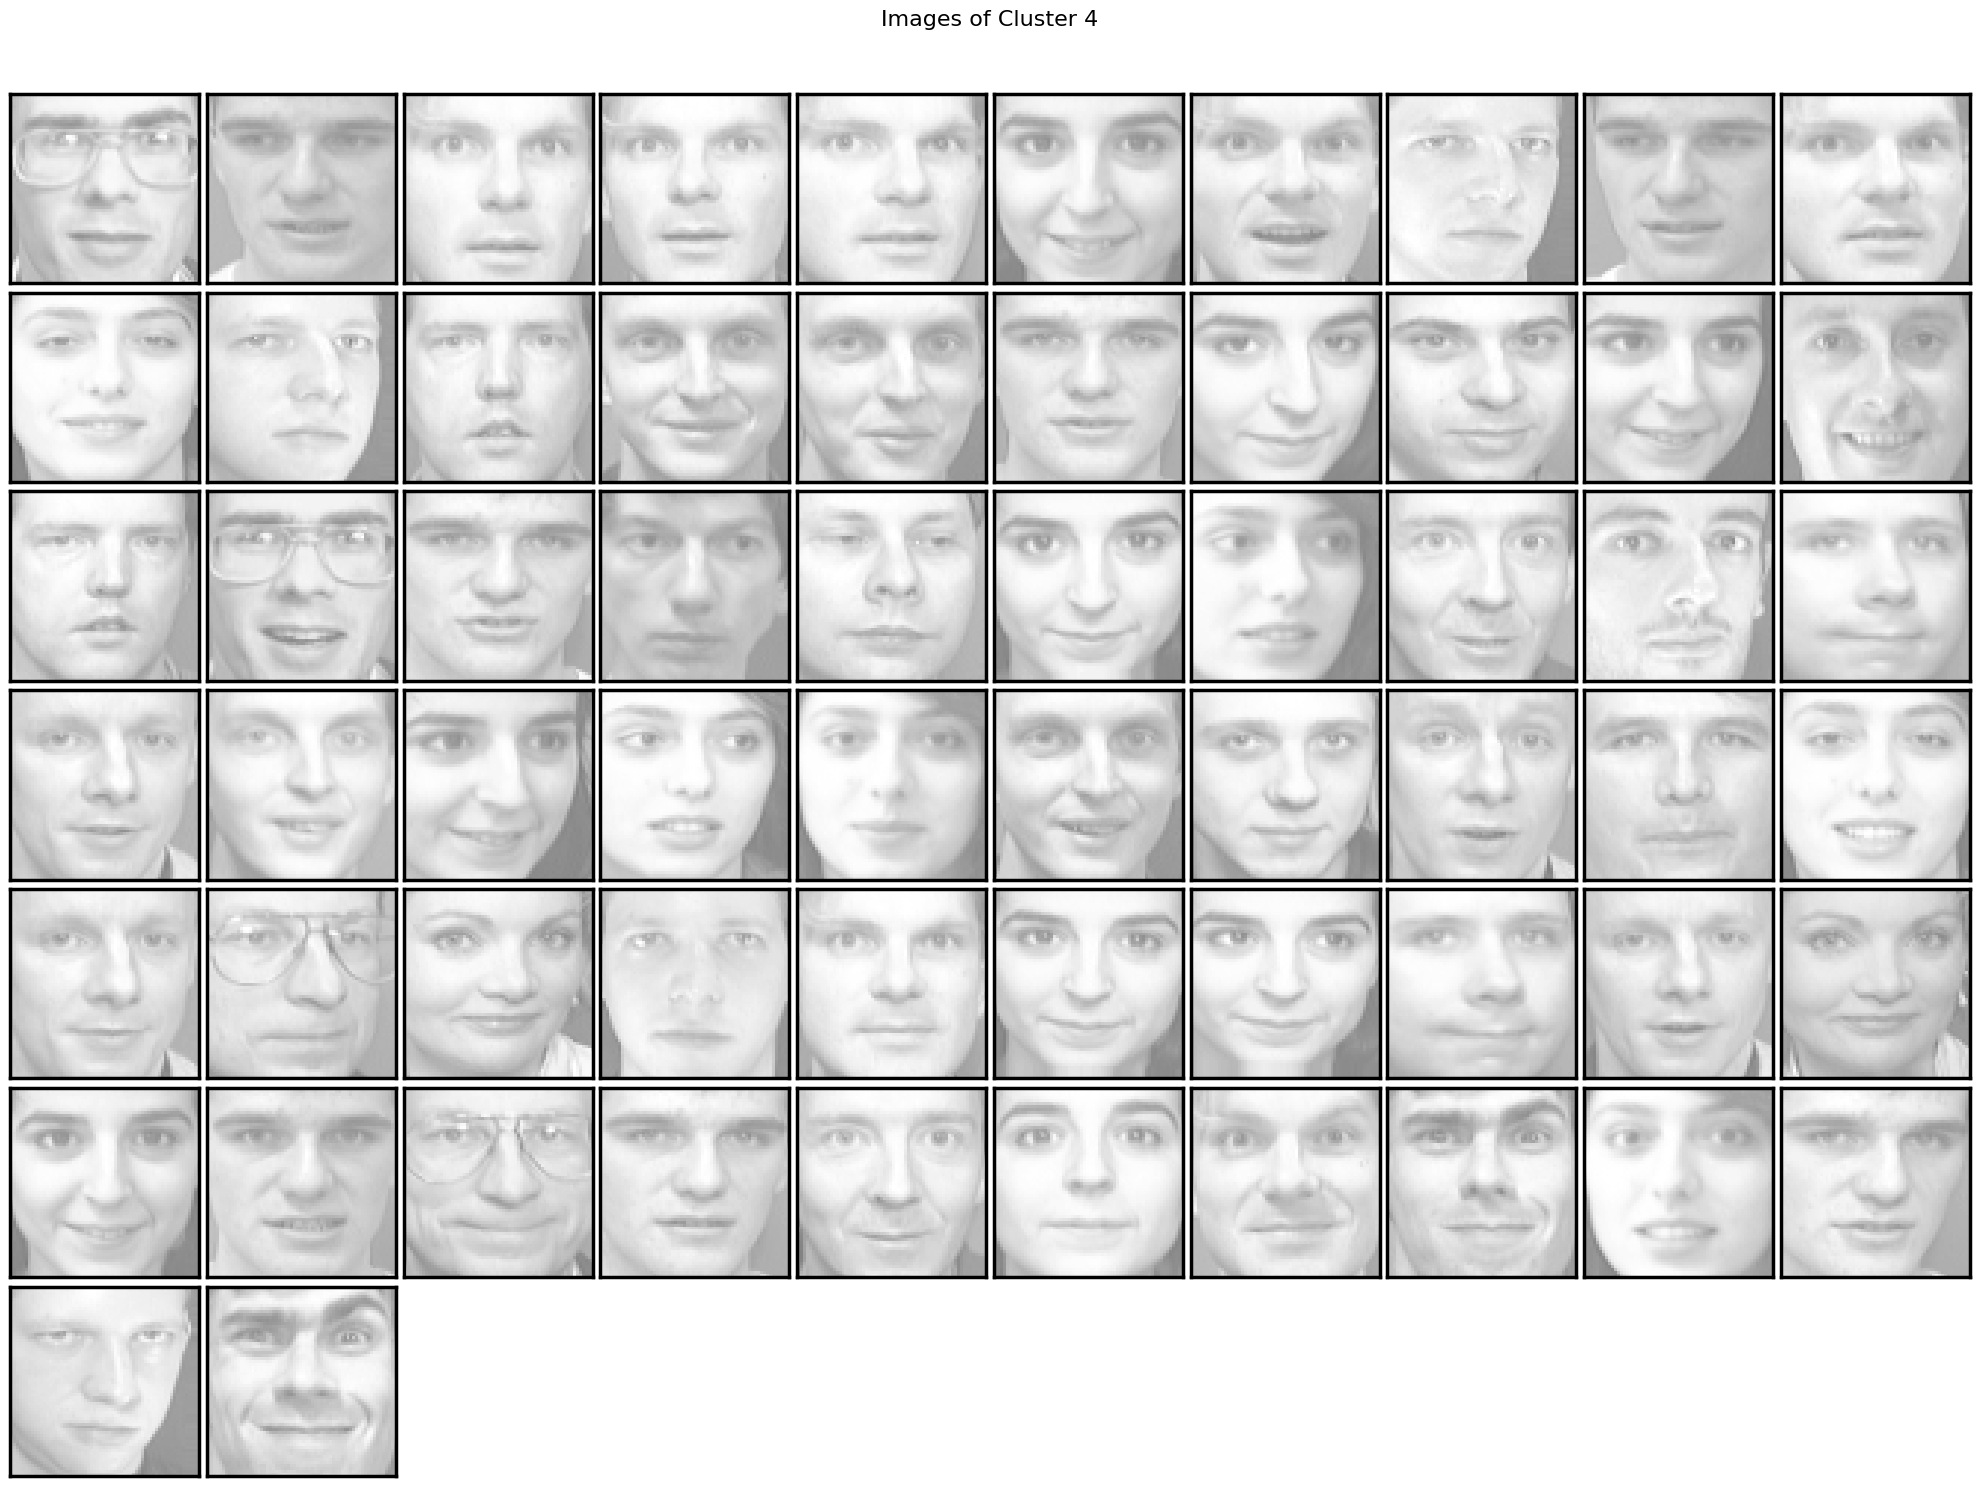

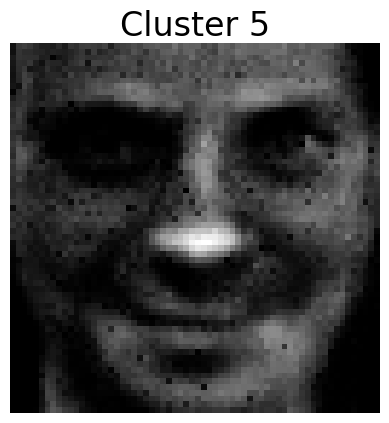

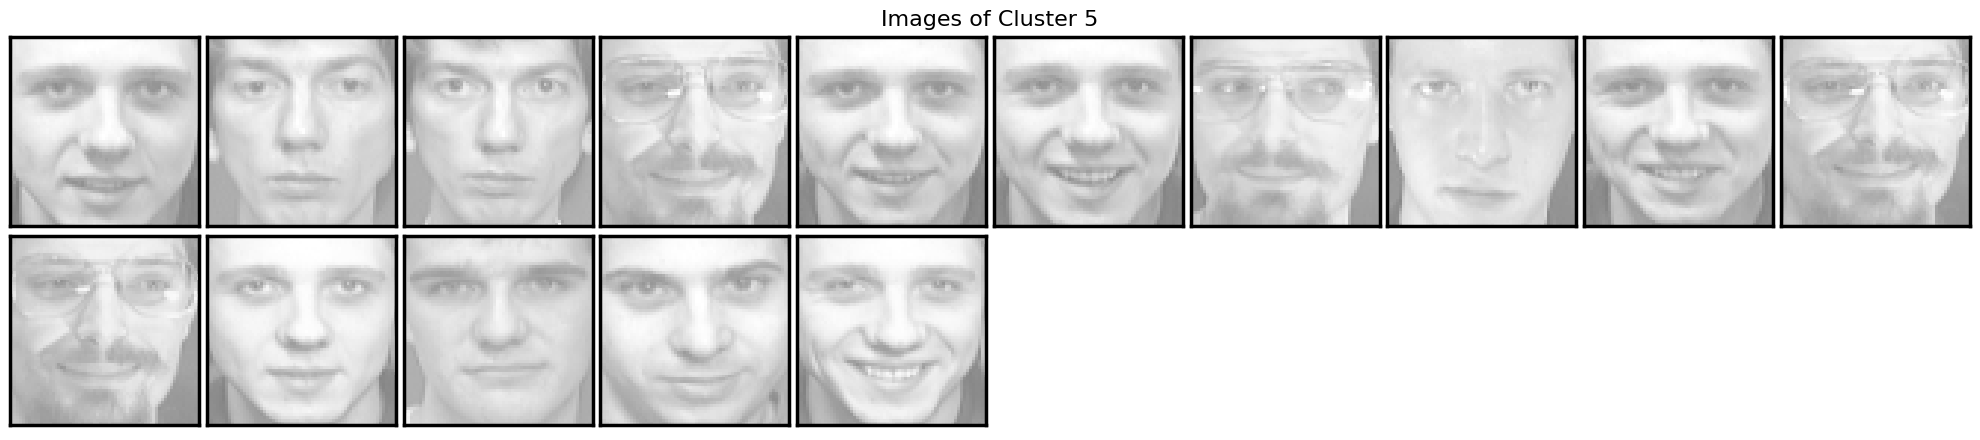

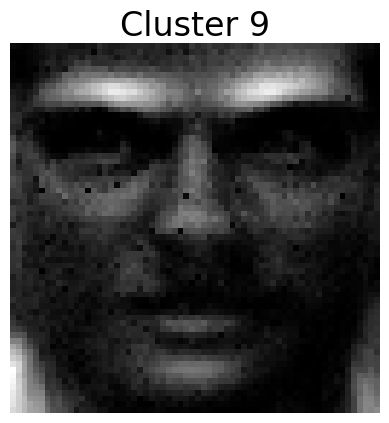

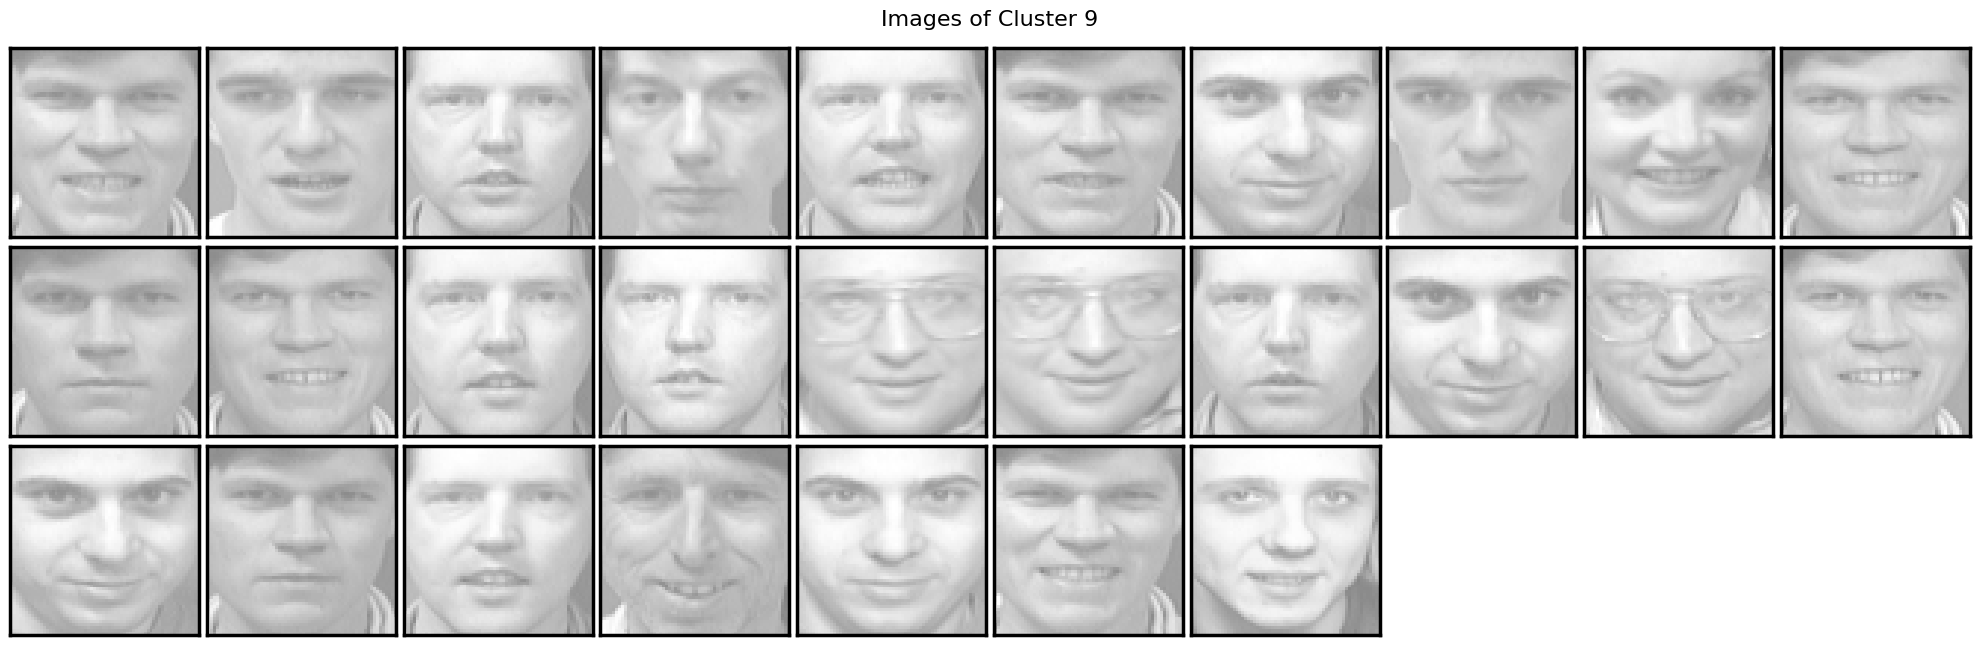

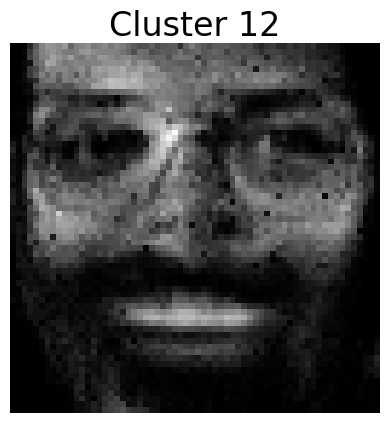

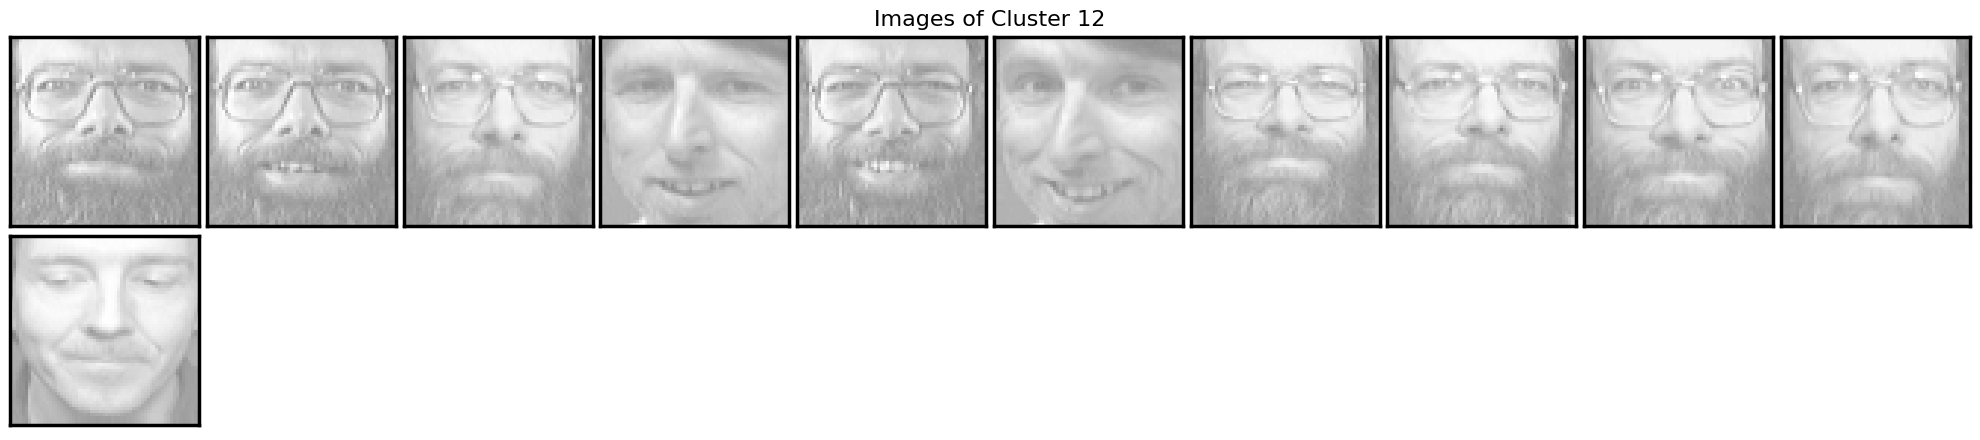

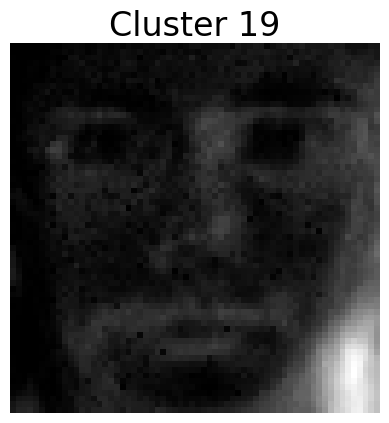

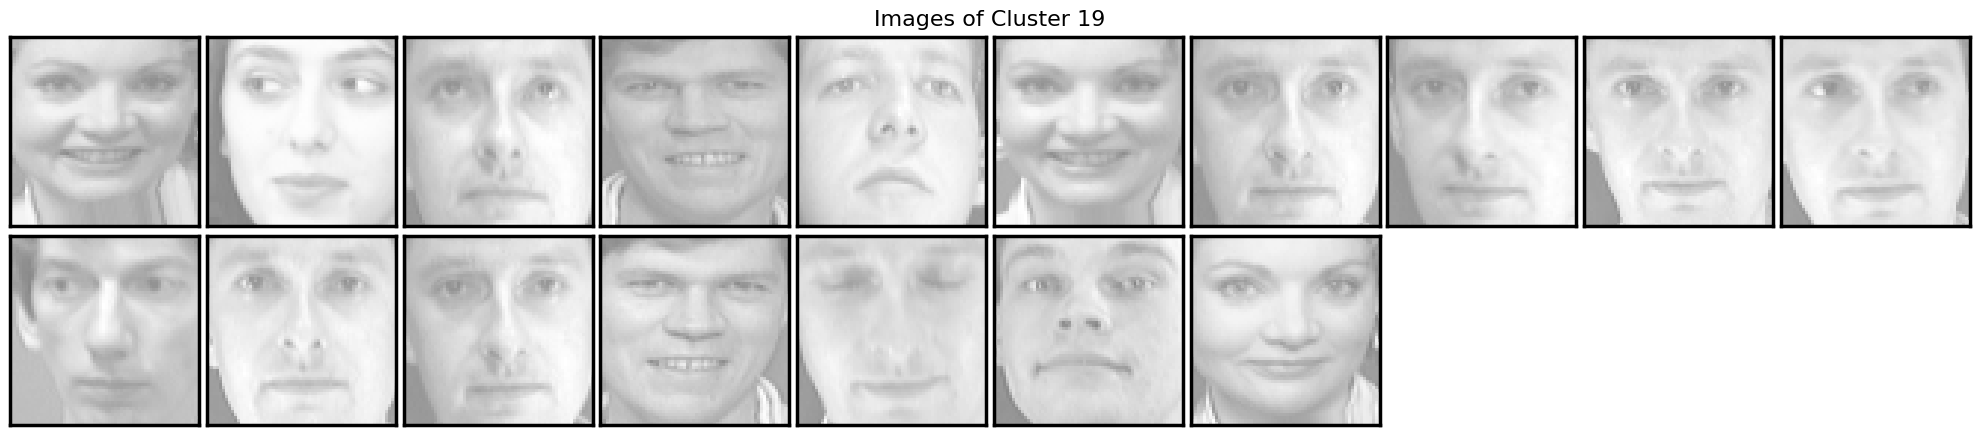

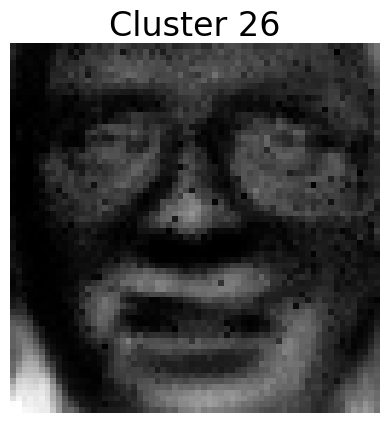

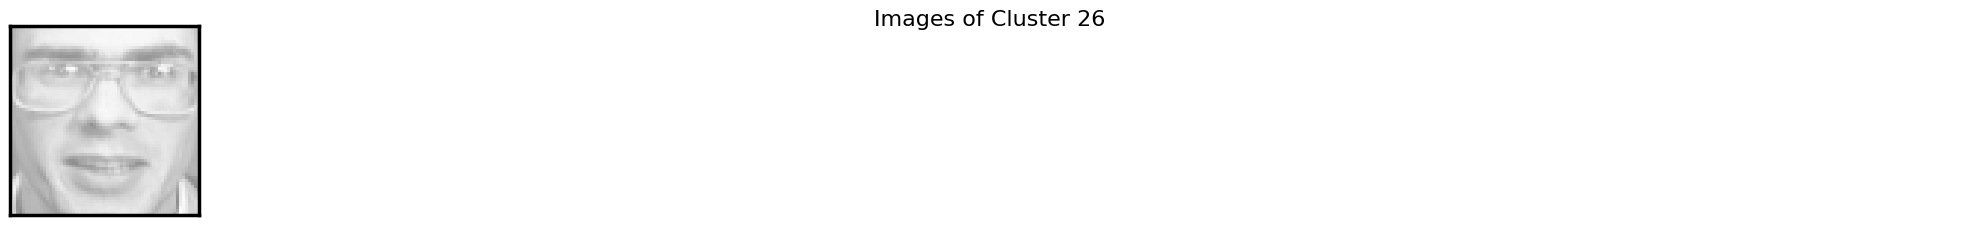

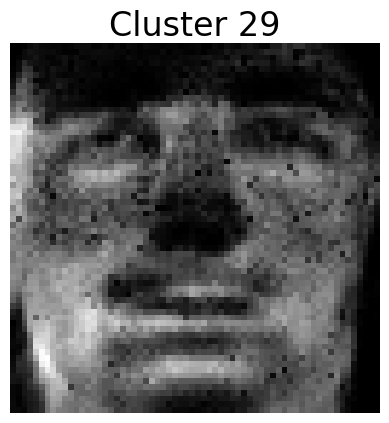

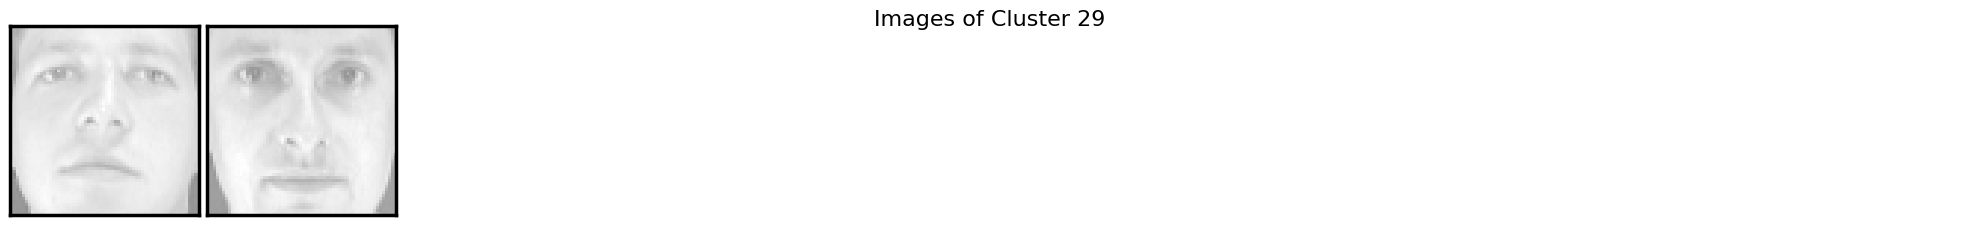

In [13]:
for i in set(sorted(clusters)):
    plt.imshow(nmf.D_[:, i].reshape(image_shape), cmap=plt.cm.gray)
    plt.title("Cluster {}".format(i))
    plt.axis('off')

    n_cluster = len(faces[clusters == i])
    plot_gallery(title="Images of Cluster {}".format(i), images=faces[clusters == i][:], image_shape=image_shape, nrow=max(1, n_cluster//10 + 1), ncol=10)
    plt.show()


### Second application 

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [58]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the 20 Newsgroups dataset 
newsgroups_data = fetch_20newsgroups(subset='train')

print("List of the different topics in the dataset")
for topic in newsgroups_data.target_names:
    print(topic)

List of the different topics in the dataset
alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


In [ ]:
# Apply TfidfVectorizer with stop words removal
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) 
X = vectorizer.fit_transform(newsgroups_data.data)

# SApply NMF to find topics
num_topics = 10
nmf_model = NMF(n_components=num_topics, max_iter=400, random_state=1)
W = nmf_model.fit_transform(X)  # Topic-document matrix
H = nmf_model.components_  # Term-topic matrix

# Display the most common words of each topic
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10  

for topic_idx, topic in enumerate(H):
    print(f"Topic #{topic_idx + 1}:")
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(", ".join(top_words))
    print()


Topic #1:
people, don, just, think, like, time, right, know, good, car

Topic #2:
edu, university, host, nntp, posting, organization, subject, lines, article, cc

Topic #3:
com, netcom, article, hp, writes, organization, subject, lines, posting, ibm

Topic #4:
windows, card, drive, dos, file, use, thanks, files, help, problem

Topic #5:
ca, team, game, hockey, canada, year, players, games, play, season

Topic #6:
key, clipper, chip, encryption, keys, escrow, government, algorithm, public, security

Topic #7:
uk, ac, university, ed, 44, subject, lines, organization, newsreader, __

Topic #8:
nasa, gov, space, research, center, ___, moon, __, access, digex

Topic #9:
cs, pitt, gordon, banks, science, edu, computer, pittsburgh, univ, soon

Topic #10:
god, jesus, bible, christian, christians, christ, faith, believe, church, people



We observe that the words extracted for each topic are relevant to the themes we identified earlier. For example, terms like 'god,' 'jesus,' and 'bible' are strongly related to religious topics, while words such as 'nasa,' 'gov,' and 'research' are more associated with the 'sci.space' category. Overall, the extracted words align well with the expected topics, which is a positive indicator of the NMF model's performance.